# Lista de exercício 3

In [1]:
# Import all libraries to construct the model
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense, Activation
import multiprocessing as mp
import psutil
import time

Using TensorFlow backend.


In [3]:
data_path = 'wdbc.data'
df = pd.read_csv(data_path, header=None)
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440
6,844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,...,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368
7,84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,...,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510
8,844981,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,...,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720
9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,...,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750


In [4]:
# Separating input data and targets
cols = [0, 1]
features, targets = df.drop(df.columns[cols],axis=1), df[1]

targets = pd.get_dummies(targets)

# Split datasets to train e test
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.30)

In [5]:
# Defining a function to get memory usage
def monitor(target):
    worker_process = mp.Process(target=target)
    worker_process.start()
    p = psutil.Process(worker_process.pid)
    return p.memory_info()[0]/1024/1024

In [6]:
# Create this class to keep state of Keras history and show additional informations, because I'm using a monitor to ge a used memory
class KerasHistory:

    def __init__(self):
        self.info = None
        self.memory_usage = 0
        self.elapsed = 0

In [7]:
# Function of training
def train(model, X, y, keras_history, epochs=100, batch_size=20):
    start = time.time()
    history = model.fit(X, y, validation_split=0.20, epochs=epochs, batch_size=batch_size, verbose=2)
    keras_history.info = history
    done = time.time()
    keras_history.elapsed = done - start

In [8]:
# Show info of model
def show_info(model, X, y, keras_history):
    # list all data in history
    #print(history.history.keys())

    # summarize history for accuracy
    plt.figure(figsize=(20,10))
    plt.plot(keras_history.info.history['acc'])
    plt.plot(keras_history.info.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.figure(figsize=(20,10))
    plt.plot(keras_history.info.history['loss'])
    plt.plot(keras_history.info.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # Print memory usage
    print('Memory Usage {:2.2f} MB'.format(keras_history.memory_usage))
    
    print('Time of Processing {:4.2f}s'.format(keras_history.elapsed))
    
    score = model.evaluate(X, y, verbose=0)
    print('Accuracy {:2.2f}%'.format(score[1]*100))

In [9]:
# Building the model 1
model1 = Sequential()
model1.add(Dense(64, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='zeros'))
model1.add(Dense(32, activation='tanh'))
model1.add(Dense(2, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
model1.compile(loss = 'mean_squared_error', optimizer='sgd', metrics=['accuracy'])
model1.summary()

# Training the model 1
keras_history1 = KerasHistory()
memory_usage = monitor(target=train(model1, X_train, y_train, keras_history1))
keras_history1.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1984      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 4,130
Trainable params: 4,130
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/100
 - 0s - loss: 0.2524 - acc: 0.5849 - val_loss: 0.2400 - val_acc: 0.6125
Epoch 2/100
 - 0s - loss: 0.2397 - acc: 0.6101 - val_loss: 0.2390 - val_acc: 0.6125
Epoch 3/100
 - 0s - loss: 0.2373 - acc: 0.6101 - val_loss: 0.2373 - val_acc: 0.6125
Epoch 4/100
 - 0s - loss: 0.2400 - acc: 0.6101 - val_loss: 0.2339 - val_acc: 0.6125
Epoch 5/100
 - 0s - los

Epoch 89/100
 - 0s - loss: 0.2381 - acc: 0.6101 - val_loss: 0.2373 - val_acc: 0.6125
Epoch 90/100
 - 0s - loss: 0.2382 - acc: 0.6101 - val_loss: 0.2373 - val_acc: 0.6125
Epoch 91/100
 - 0s - loss: 0.2383 - acc: 0.6101 - val_loss: 0.2373 - val_acc: 0.6125
Epoch 92/100
 - 0s - loss: 0.2381 - acc: 0.6101 - val_loss: 0.2373 - val_acc: 0.6125
Epoch 93/100
 - 0s - loss: 0.2381 - acc: 0.6101 - val_loss: 0.2373 - val_acc: 0.6125
Epoch 94/100
 - 0s - loss: 0.2380 - acc: 0.6101 - val_loss: 0.2373 - val_acc: 0.6125
Epoch 95/100
 - 0s - loss: 0.2381 - acc: 0.6101 - val_loss: 0.2373 - val_acc: 0.6125
Epoch 96/100
 - 0s - loss: 0.2381 - acc: 0.6101 - val_loss: 0.2373 - val_acc: 0.6125
Epoch 97/100
 - 0s - loss: 0.2380 - acc: 0.6101 - val_loss: 0.2373 - val_acc: 0.6125
Epoch 98/100
 - 0s - loss: 0.2381 - acc: 0.6101 - val_loss: 0.2374 - val_acc: 0.6125
Epoch 99/100
 - 0s - loss: 0.2380 - acc: 0.6101 - val_loss: 0.2374 - val_acc: 0.6125
Epoch 100/100
 - 0s - loss: 0.2382 - acc: 0.6101 - val_loss: 0.23

## Respostas da questão 1

## Treinamento 1
Para o treinamento 1 foram utilizados os seguintes hiperparametros:

Épocas = 100

Batchsize = 20

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 64 e a segunda com 32 e a camada de saída com dois neurônios. Na primeira utilizei a tangente hiperbólica e na segunda a sigmóide como função de ativação.

Nesse ciclo podemos observar os resultados abaixo:

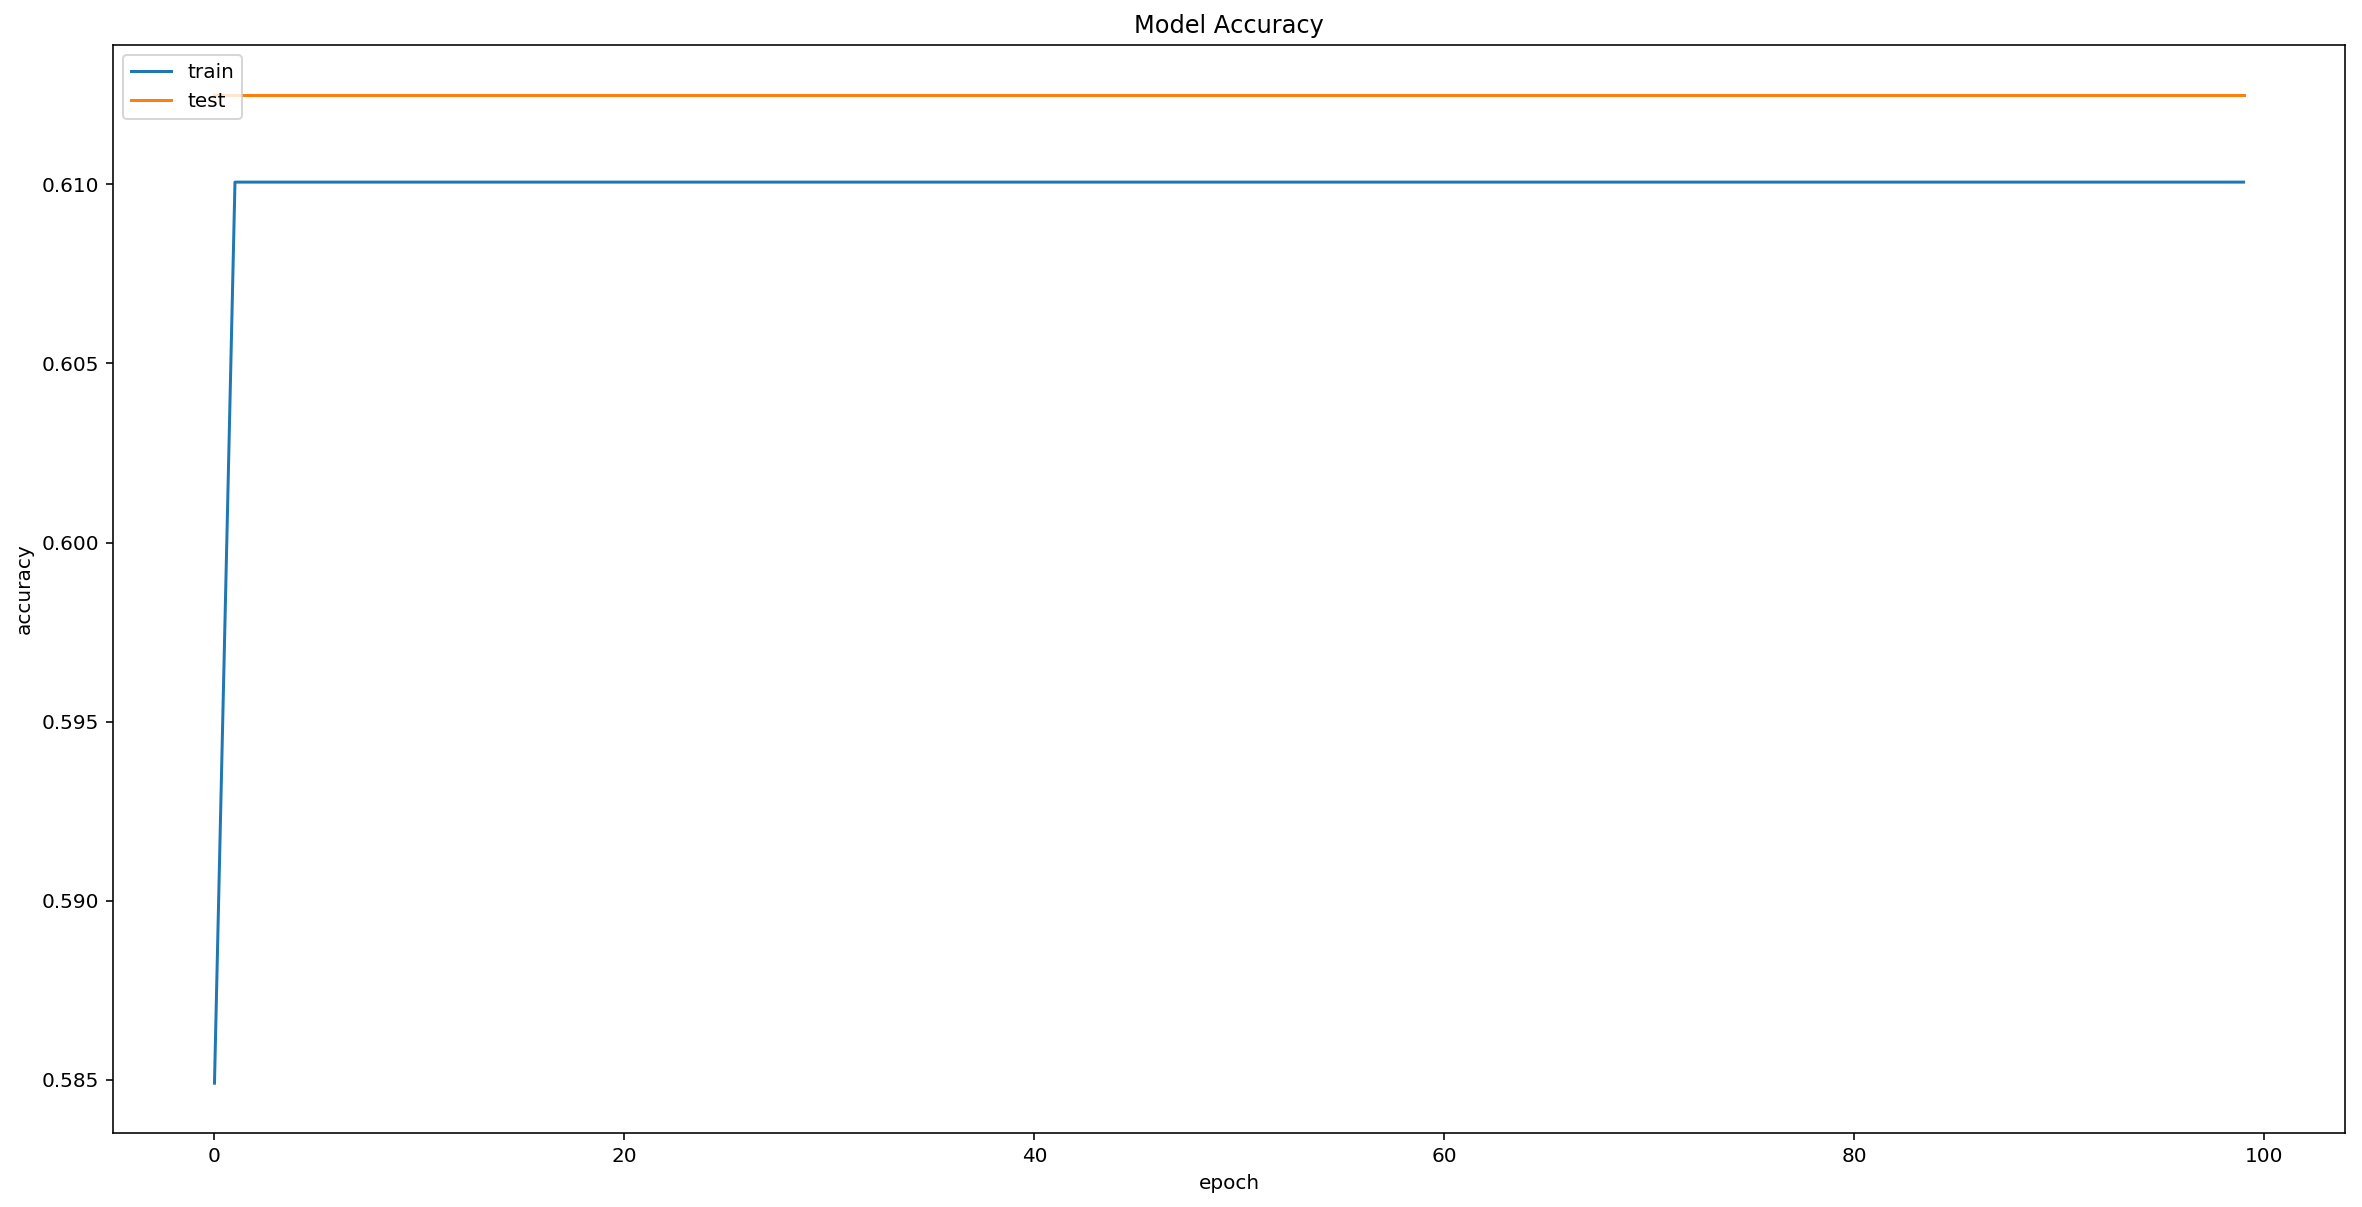

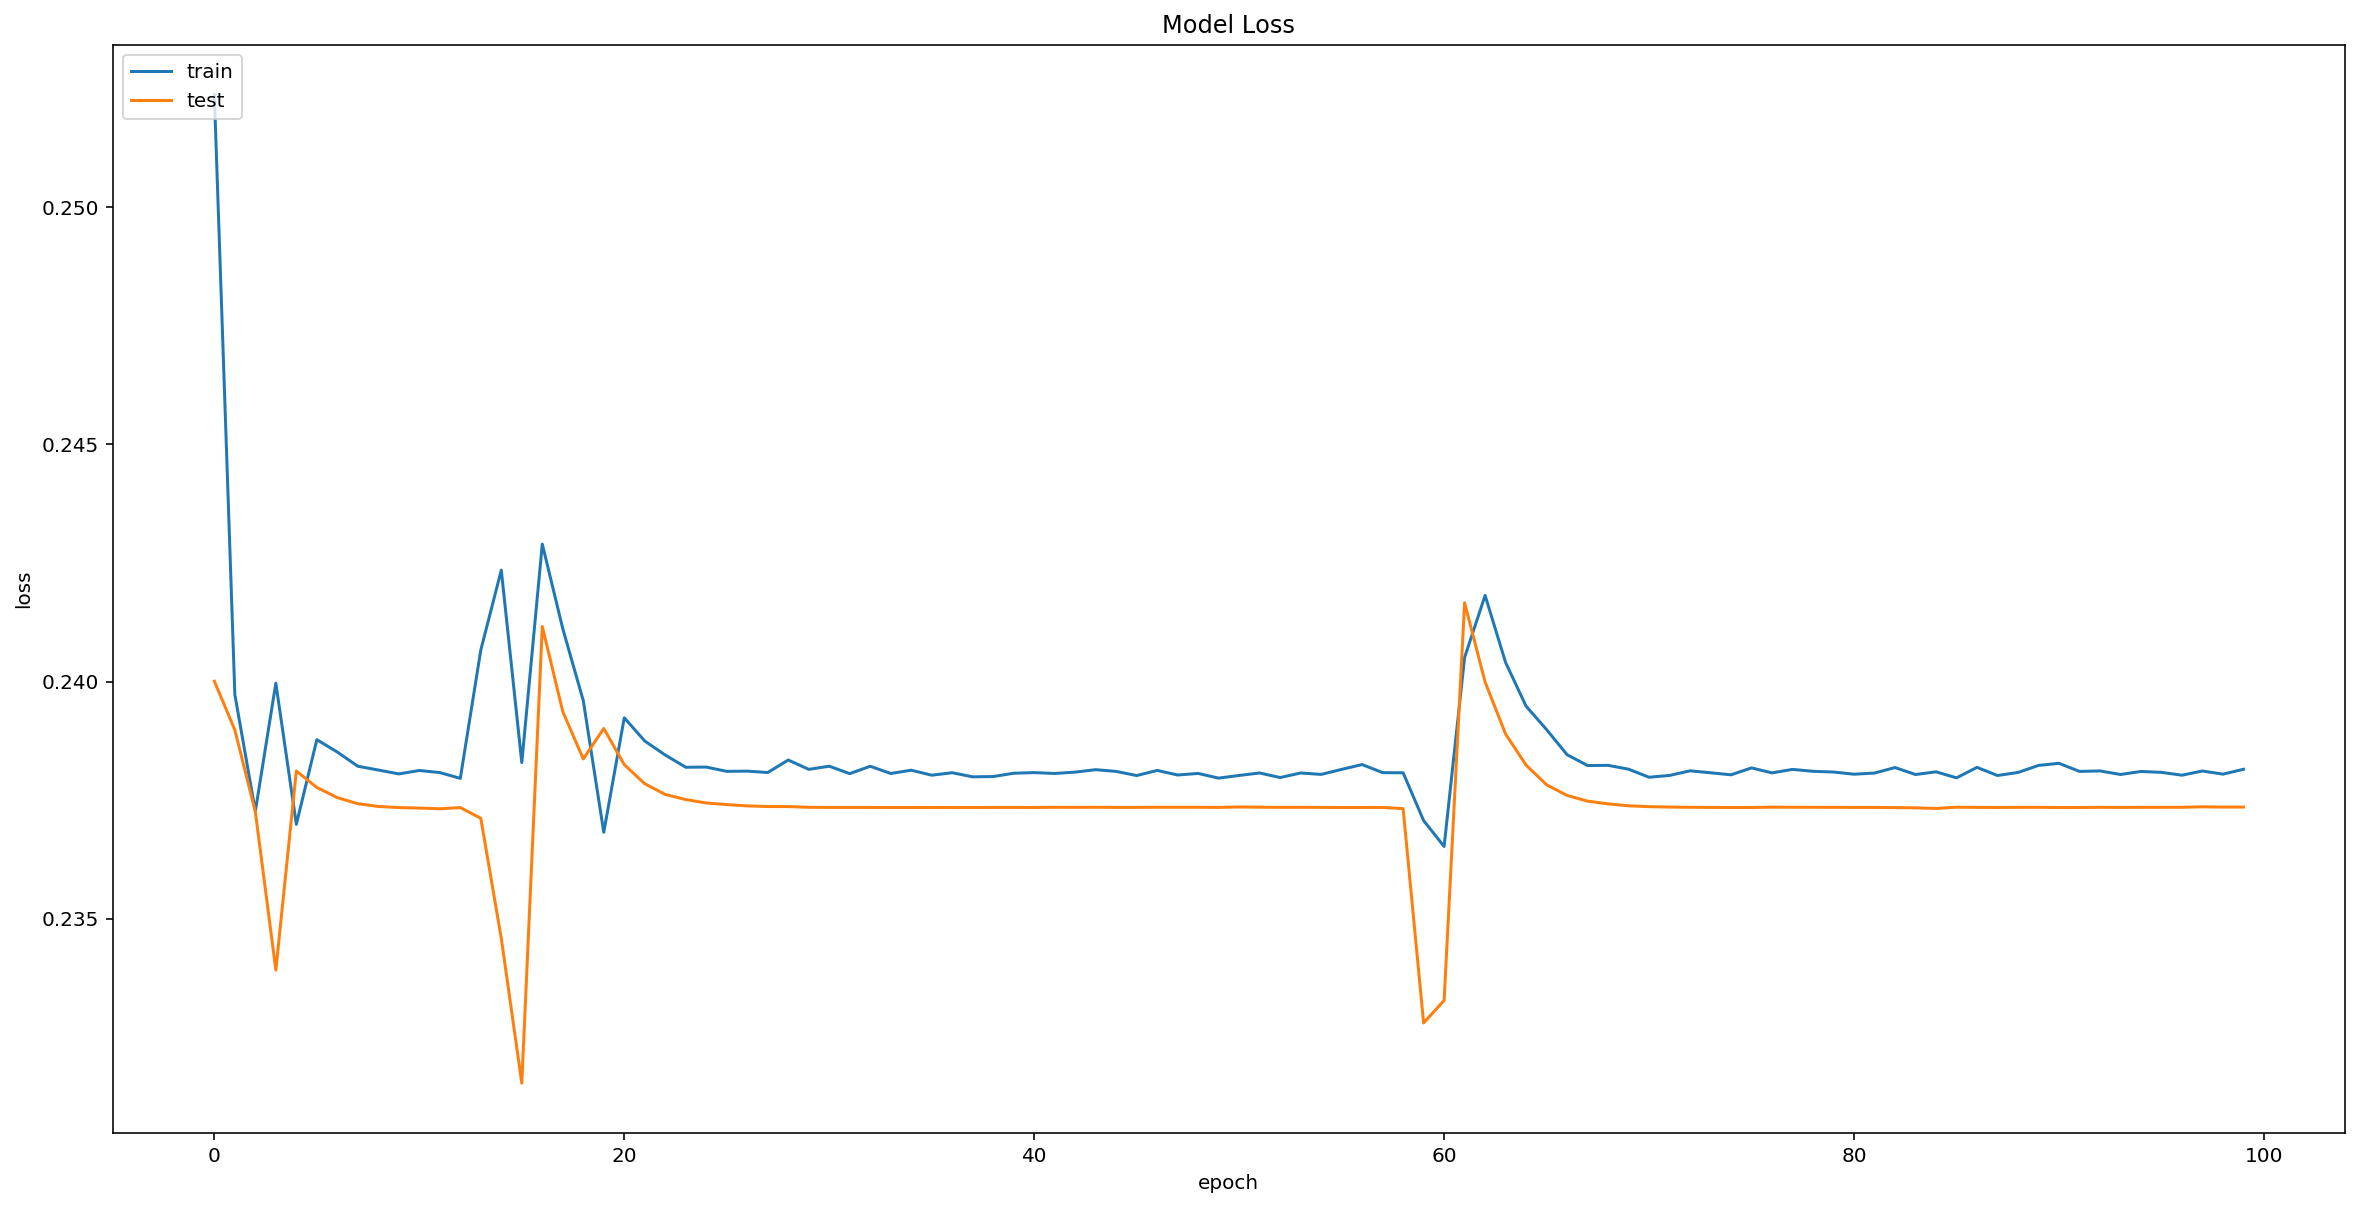

Memory Usage 1.49 MB
Time of Processing 2.84s
Accuracy 66.67%


In [10]:
show_info(model1, X_test, y_test, keras_history1)

In [11]:
# Building the model 2
model2 = Sequential()
model2.add(Dense(64, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='zeros'))
model2.add(Dense(32, activation='sigmoid'))
model2.add(Dense(2, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
model2.compile(loss = 'mean_squared_error', optimizer='adam', metrics=['accuracy'])
model2.summary()

# Training the model 2
keras_history2 = KerasHistory()
memory_usage = monitor(target=train(model2, X_train, y_train, keras_history2))
keras_history2.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                1984      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 66        
Total params: 4,130
Trainable params: 4,130
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/100
 - 0s - loss: 0.3072 - acc: 0.3899 - val_loss: 0.2512 - val_acc: 0.3625
Epoch 2/100
 - 0s - loss: 0.2318 - acc: 0.6006 - val_loss: 0.2172 - val_acc: 0.6125
Epoch 3/100
 - 0s - loss: 0.2166 - acc: 0.6101 - val_loss: 0.2084 - val_acc: 0.6125
Epoch 4/100
 - 0s - loss: 0.2093 - acc: 0.6101 - val_loss: 0.2053 - val_acc: 0.6125
Epoch 5/100
 - 0s - los

Epoch 89/100
 - 0s - loss: 0.0600 - acc: 0.9245 - val_loss: 0.0542 - val_acc: 0.9125
Epoch 90/100
 - 0s - loss: 0.0547 - acc: 0.9308 - val_loss: 0.0599 - val_acc: 0.9250
Epoch 91/100
 - 0s - loss: 0.0572 - acc: 0.9245 - val_loss: 0.0501 - val_acc: 0.9375
Epoch 92/100
 - 0s - loss: 0.0647 - acc: 0.9119 - val_loss: 0.0575 - val_acc: 0.9250
Epoch 93/100
 - 0s - loss: 0.0699 - acc: 0.8962 - val_loss: 0.0820 - val_acc: 0.8875
Epoch 94/100
 - 0s - loss: 0.0709 - acc: 0.9025 - val_loss: 0.0523 - val_acc: 0.9250
Epoch 95/100
 - 0s - loss: 0.0591 - acc: 0.9245 - val_loss: 0.0556 - val_acc: 0.9250
Epoch 96/100
 - 0s - loss: 0.0627 - acc: 0.9088 - val_loss: 0.0575 - val_acc: 0.9250
Epoch 97/100
 - 0s - loss: 0.0618 - acc: 0.9214 - val_loss: 0.0528 - val_acc: 0.9250
Epoch 98/100
 - 0s - loss: 0.0536 - acc: 0.9245 - val_loss: 0.0549 - val_acc: 0.9250
Epoch 99/100
 - 0s - loss: 0.0566 - acc: 0.9182 - val_loss: 0.0606 - val_acc: 0.9125
Epoch 100/100
 - 0s - loss: 0.0703 - acc: 0.8836 - val_loss: 0.05

## Treinamento 2
Para o treinamento 2 foram utilizados os seguintes hiperparametros:

Épocas = 100

Batchsize = 20

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 64 e a segunda com 32 e a camada de saída com dois neurônios. Na primeira e na segunda camada utilizei a sigmóide como função de ativação. Nesse treinamento ao invés de utilizar o SGD como otimizador da função de perda, utilizei o Adam.

Nesse ciclo podemos observar os resultados abaixo:

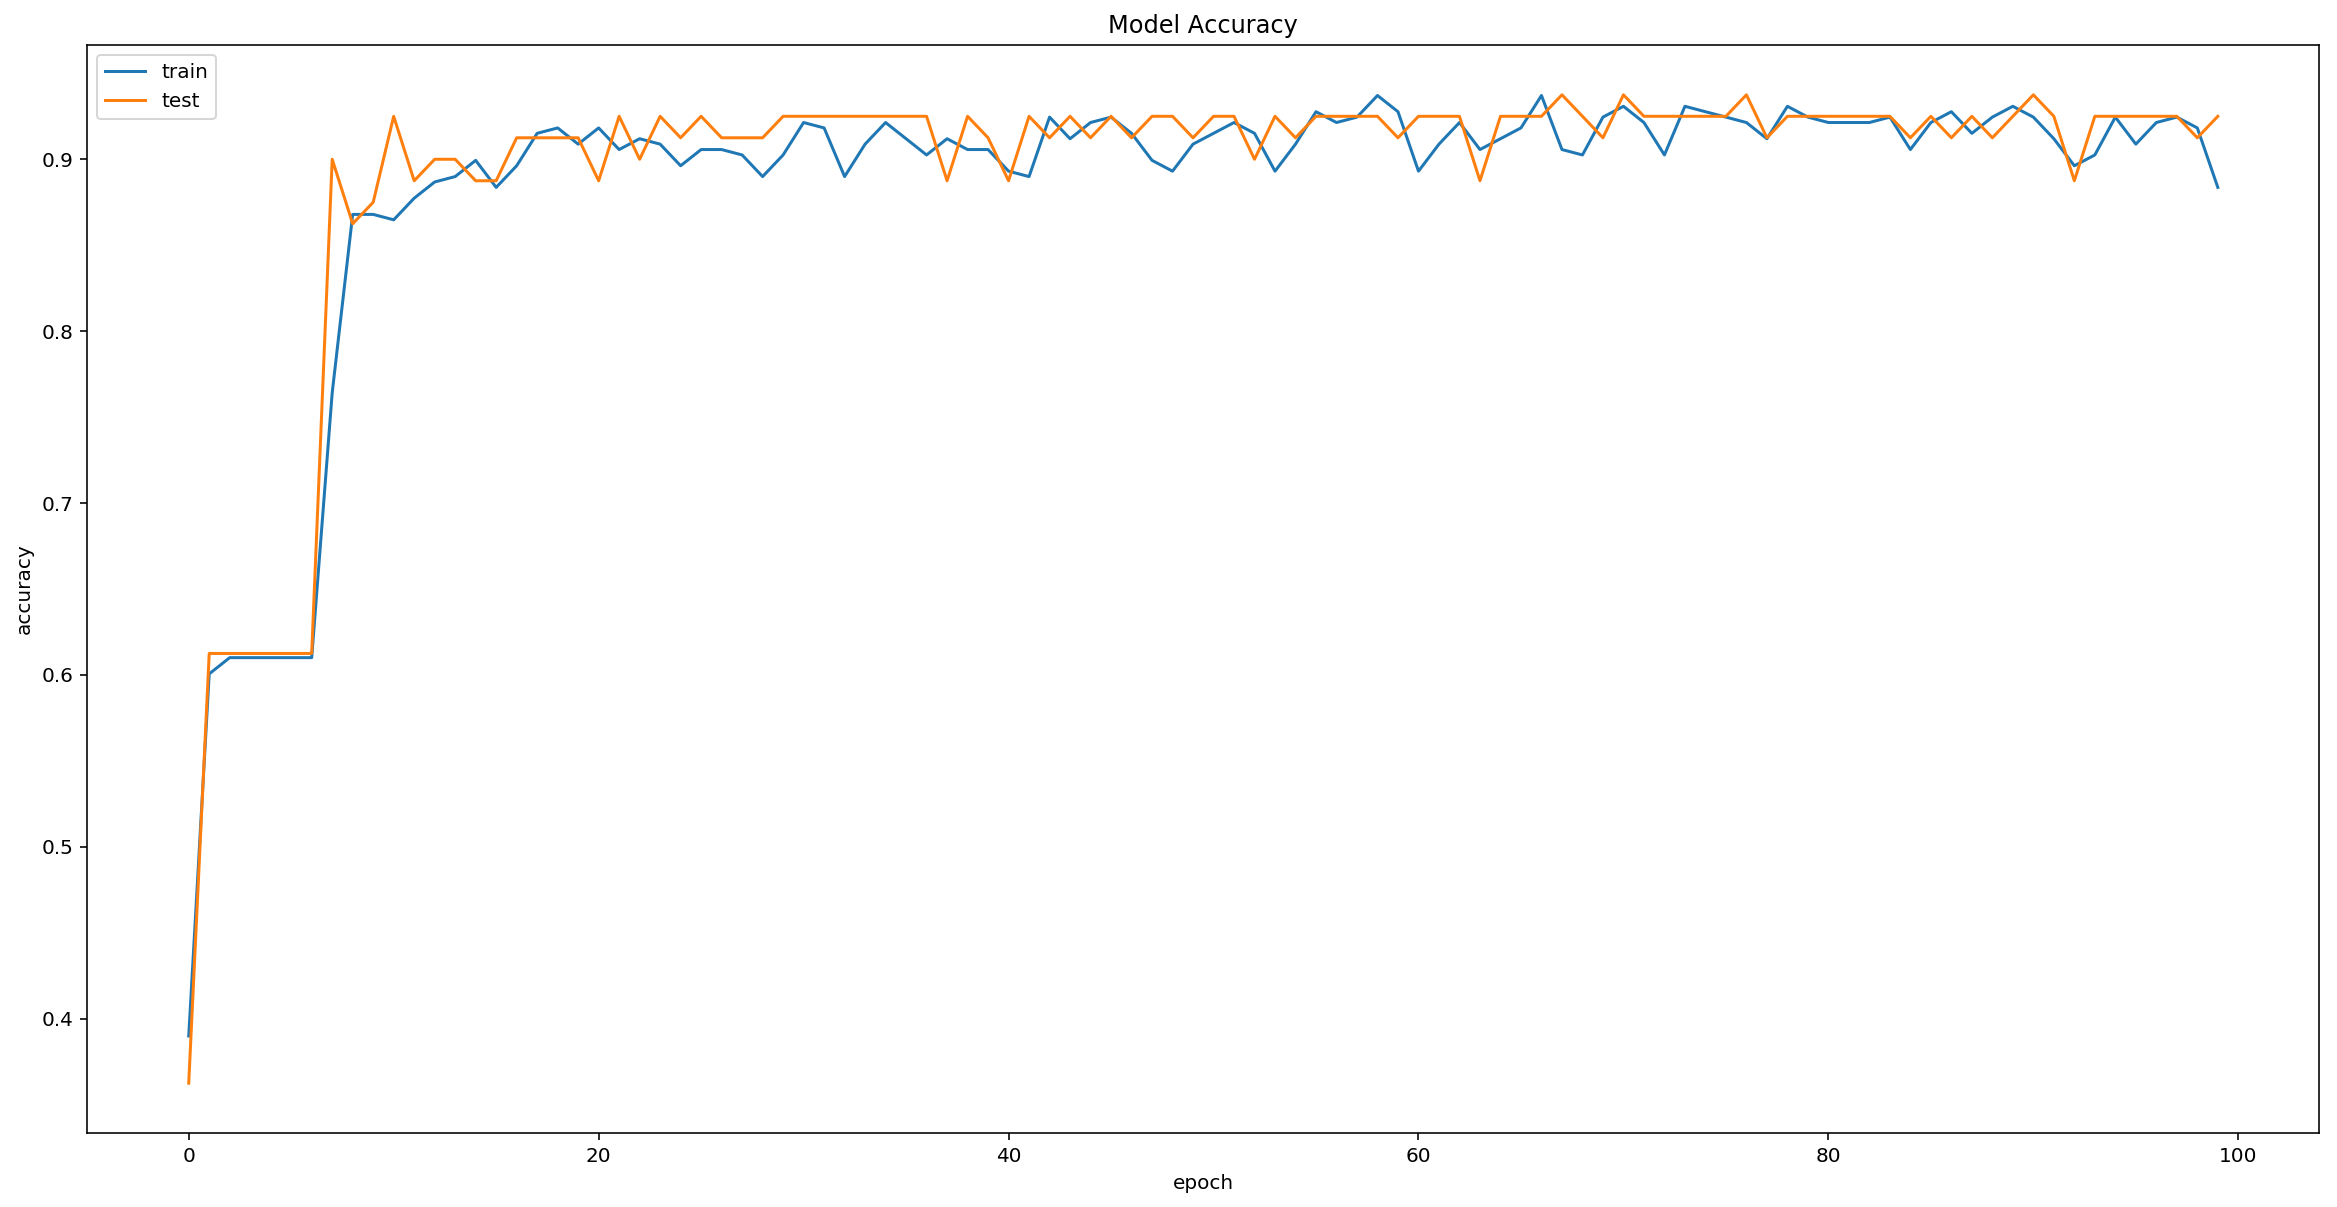

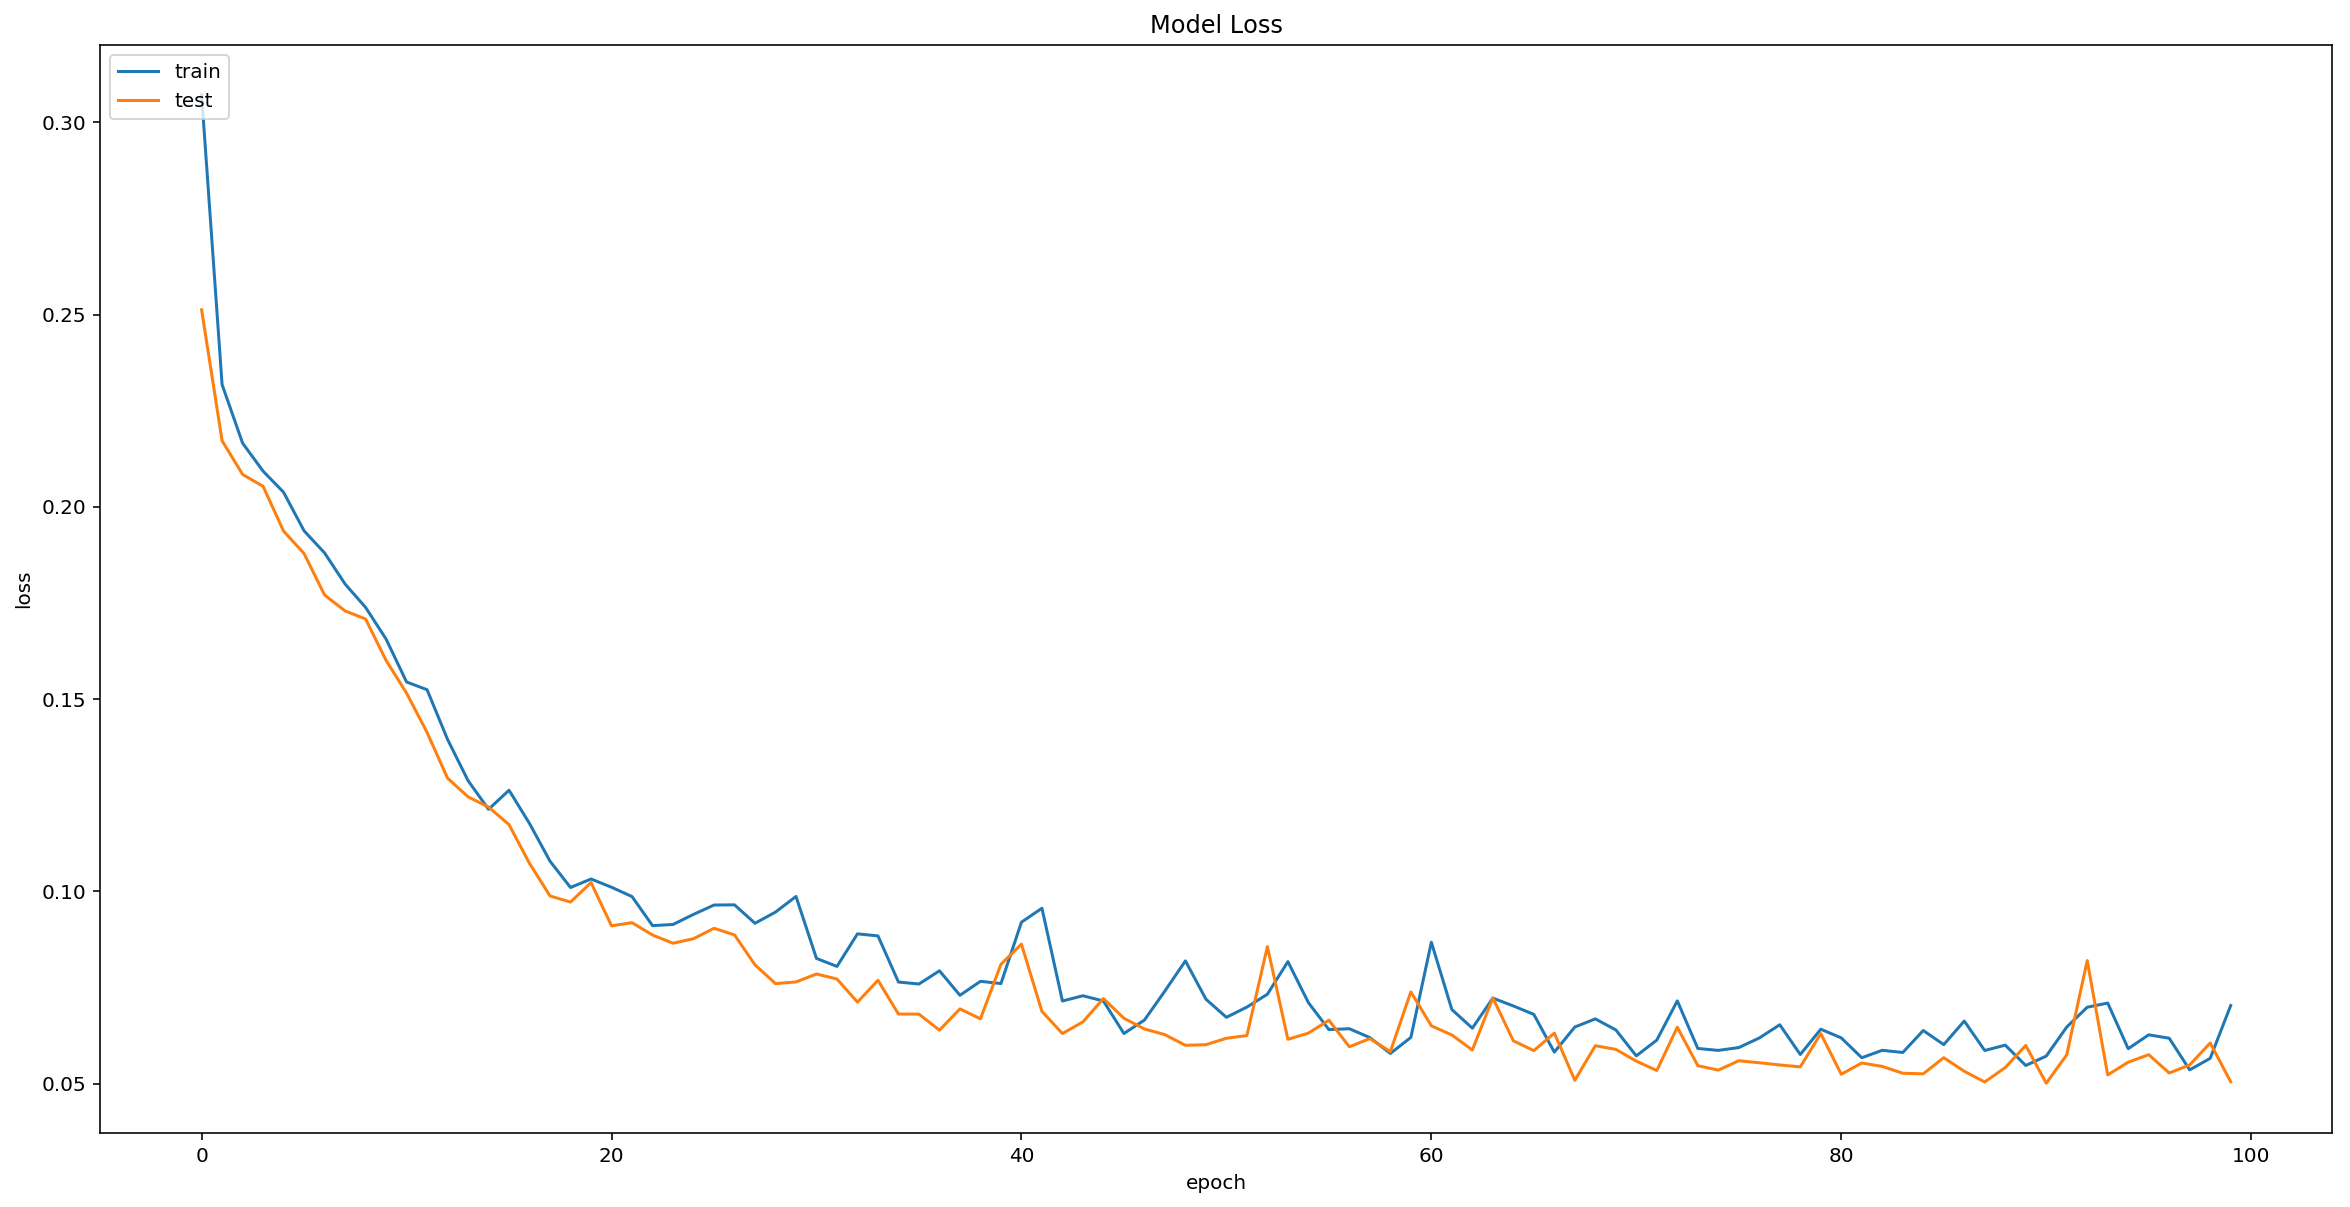

Memory Usage 1.64 MB
Time of Processing 3.77s
Accuracy 92.40%


In [12]:
show_info(model2, X_test, y_test, keras_history2)

In [13]:
# Building the model 3
model3 = Sequential()
model3.add(Dense(64, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='zeros'))
model3.add(Dense(32, activation='tanh'))
model3.add(Dense(2, activation='tanh'))

# Compile model with loss function, optmizer and metrics
model3.compile(loss = 'mean_squared_error', optimizer='adam', metrics=['accuracy'])
model3.summary()

# Training the model 3
keras_history3 = KerasHistory()
memory_usage = monitor(target=train(model3, X_train, y_train, keras_history3))
keras_history3.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                1984      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 66        
Total params: 4,130
Trainable params: 4,130
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/100
 - 0s - loss: 0.3113 - acc: 0.5346 - val_loss: 0.2626 - val_acc: 0.6125
Epoch 2/100
 - 0s - loss: 0.2515 - acc: 0.6101 - val_loss: 0.2315 - val_acc: 0.6125
Epoch 3/100
 - 0s - loss: 0.2316 - acc: 0.6101 - val_loss: 0.2248 - val_acc: 0.6125
Epoch 4/100
 - 0s - loss: 0.2183 - acc: 0.6101 - val_loss: 0.2072 - val_acc: 0.6125
Epoch 5/100
 - 0s - los

Epoch 89/100
 - 0s - loss: 0.2386 - acc: 0.6101 - val_loss: 0.2374 - val_acc: 0.6125
Epoch 90/100
 - 0s - loss: 0.2383 - acc: 0.6101 - val_loss: 0.2374 - val_acc: 0.6125
Epoch 91/100
 - 0s - loss: 0.2383 - acc: 0.6101 - val_loss: 0.2373 - val_acc: 0.6125
Epoch 92/100
 - 0s - loss: 0.2381 - acc: 0.6101 - val_loss: 0.2373 - val_acc: 0.6125
Epoch 93/100
 - 0s - loss: 0.2383 - acc: 0.6101 - val_loss: 0.2374 - val_acc: 0.6125
Epoch 94/100
 - 0s - loss: 0.2402 - acc: 0.6101 - val_loss: 0.2375 - val_acc: 0.6125
Epoch 95/100
 - 0s - loss: 0.2384 - acc: 0.6101 - val_loss: 0.2375 - val_acc: 0.6125
Epoch 96/100
 - 0s - loss: 0.2383 - acc: 0.6101 - val_loss: 0.2376 - val_acc: 0.6125
Epoch 97/100
 - 0s - loss: 0.2393 - acc: 0.6101 - val_loss: 0.2375 - val_acc: 0.6125
Epoch 98/100
 - 0s - loss: 0.2391 - acc: 0.6101 - val_loss: 0.2378 - val_acc: 0.6125
Epoch 99/100
 - 0s - loss: 0.2425 - acc: 0.6101 - val_loss: 0.2377 - val_acc: 0.6125
Epoch 100/100
 - 0s - loss: 0.2387 - acc: 0.6101 - val_loss: 0.23

## Treinamento 3
Para o treinamento 3 foram utilizados os seguintes hiperparametros:

Épocas = 100

Batchsize = 20

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 64 e a segunda com 32 e a camada de saída com dois neurônios. Na primeira e na segunda camada utilizei a tangente hiperbólica como função de ativação. Nesse treinamento ao invés de utilizar o SGD como otimizador da função de perda, utilizei o Adam.

Nesse ciclo podemos observar os resultados abaixo:

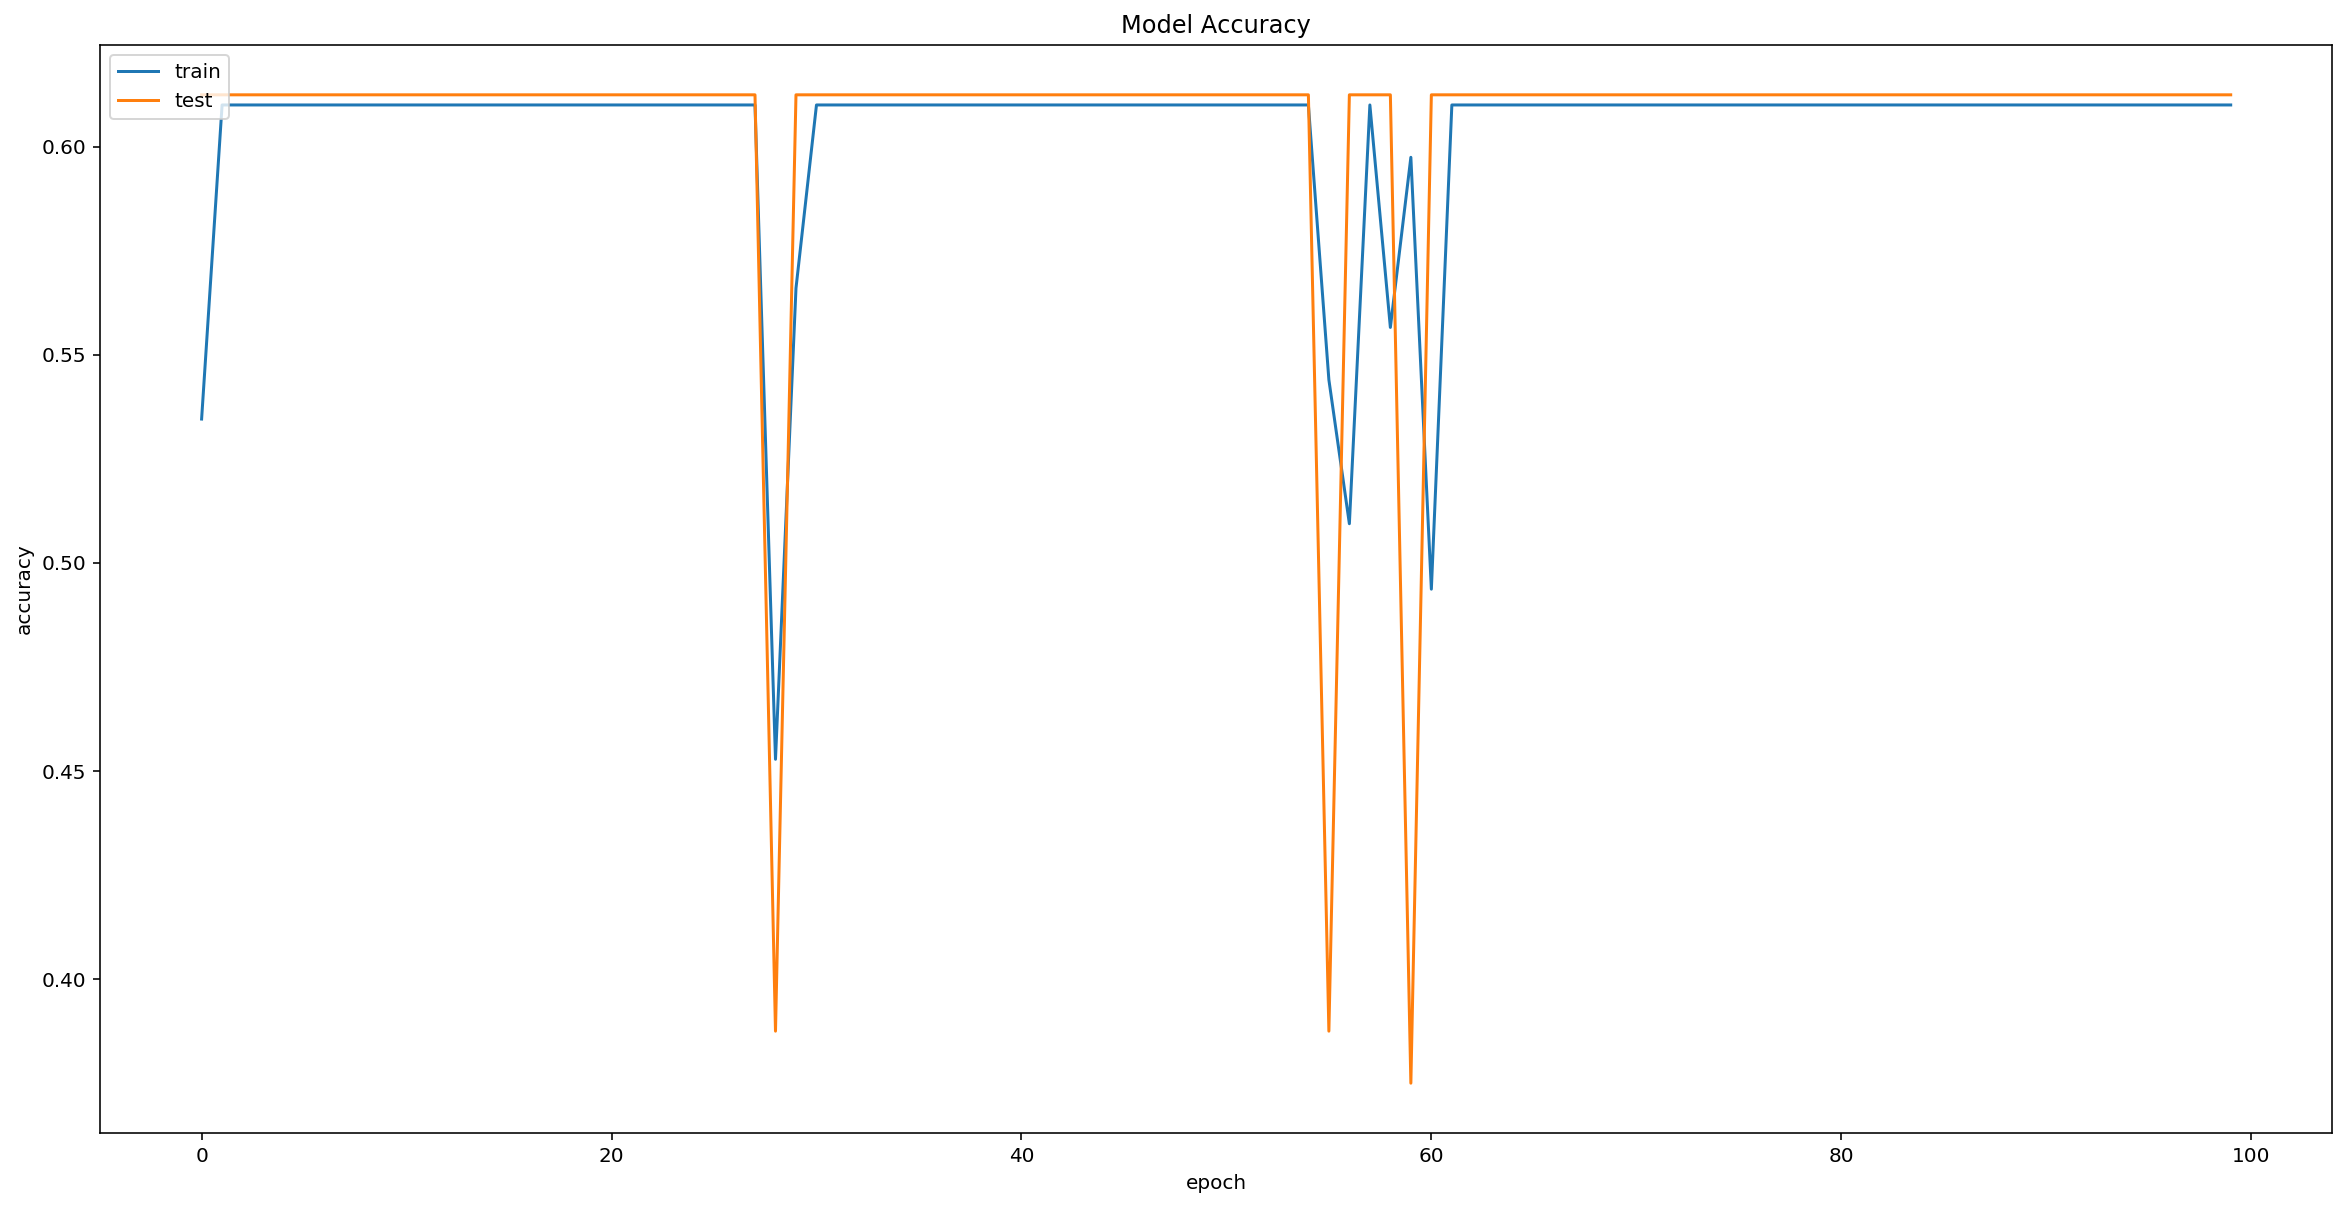

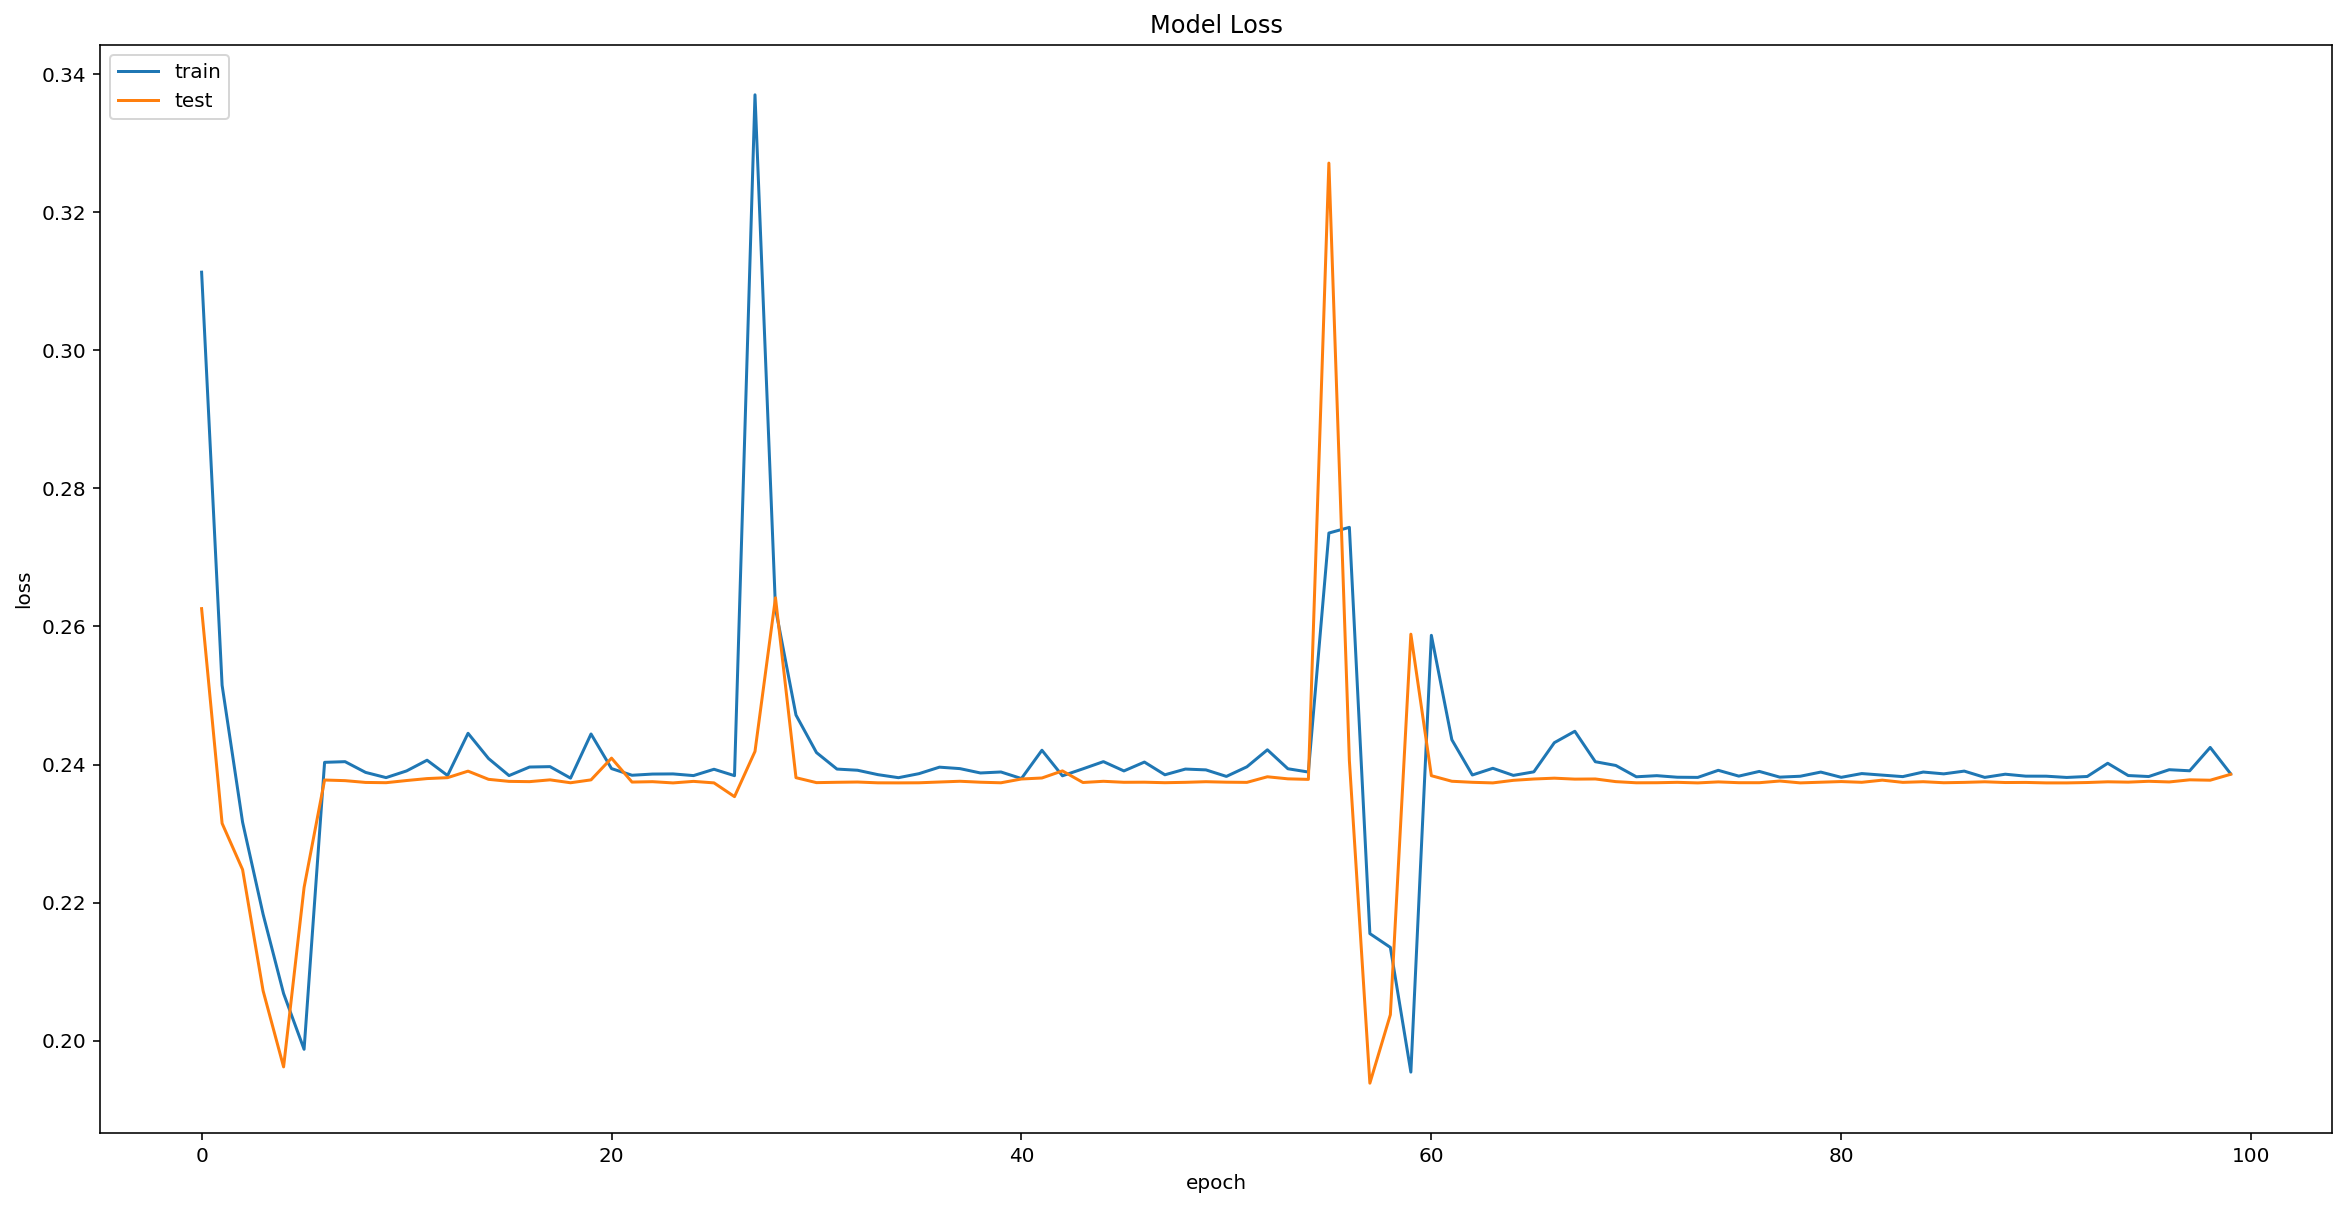

Memory Usage 1.21 MB
Time of Processing 3.81s
Accuracy 66.67%


In [14]:
show_info(model3, X_test, y_test, keras_history3)

In [15]:
# Normalization of data
X_train_norm = (X_train - X_train.mean()) / (X_train.max() - X_train.min())
X_test_norm = (X_test - X_test.mean()) / (X_test.max() - X_test.min())

In [16]:
# Building the model 4
model4 = Sequential()
model4.add(Dense(32, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='zeros'))
model4.add(Dense(16, activation='tanh'))
model4.add(Dense(2, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
model4.compile(loss = 'mean_squared_error', optimizer='sgd', metrics=['accuracy'])
model4.summary()

# Training the model 4
keras_history4 = KerasHistory()
memory_usage = monitor(target=train(model4, X_train_norm, y_train, keras_history4, epochs=50))
keras_history4.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 32)                992       
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 34        
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/50
 - 0s - loss: 0.2452 - acc: 0.8994 - val_loss: 0.2441 - val_acc: 0.8875
Epoch 2/50
 - 0s - loss: 0.2435 - acc: 0.8616 - val_loss: 0.2425 - val_acc: 0.8250
Epoch 3/50
 - 0s - loss: 0.2419 - acc: 0.8050 - val_loss: 0.2409 - val_acc: 0.8125
Epoch 4/50
 - 0s - loss: 0.2404 - acc: 0.7767 - val_loss: 0.2393 - val_acc: 0.7625
Epoch 5/50
 - 0s - loss: 0.

## Treinamento 4
Para o treinamento 4 foram utilizados os seguintes hiperparametros:

Épocas = 50

Batchsize = 20

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 32 e a segunda com 16 e a camada de saída com dois neurônios. Na primeira utilizei a tangente hiperbólica e na segunda a sigmóide como função de ativação. Uma técnica utilizada nesse caso foi normalizar os dados, com isso foi possível diminuir o número de neurônios nas camadas ocultas, o número de épocas foi a metade e a precisão do modelo melhorou.

Nesse ciclo podemos observar os resultados abaixo:

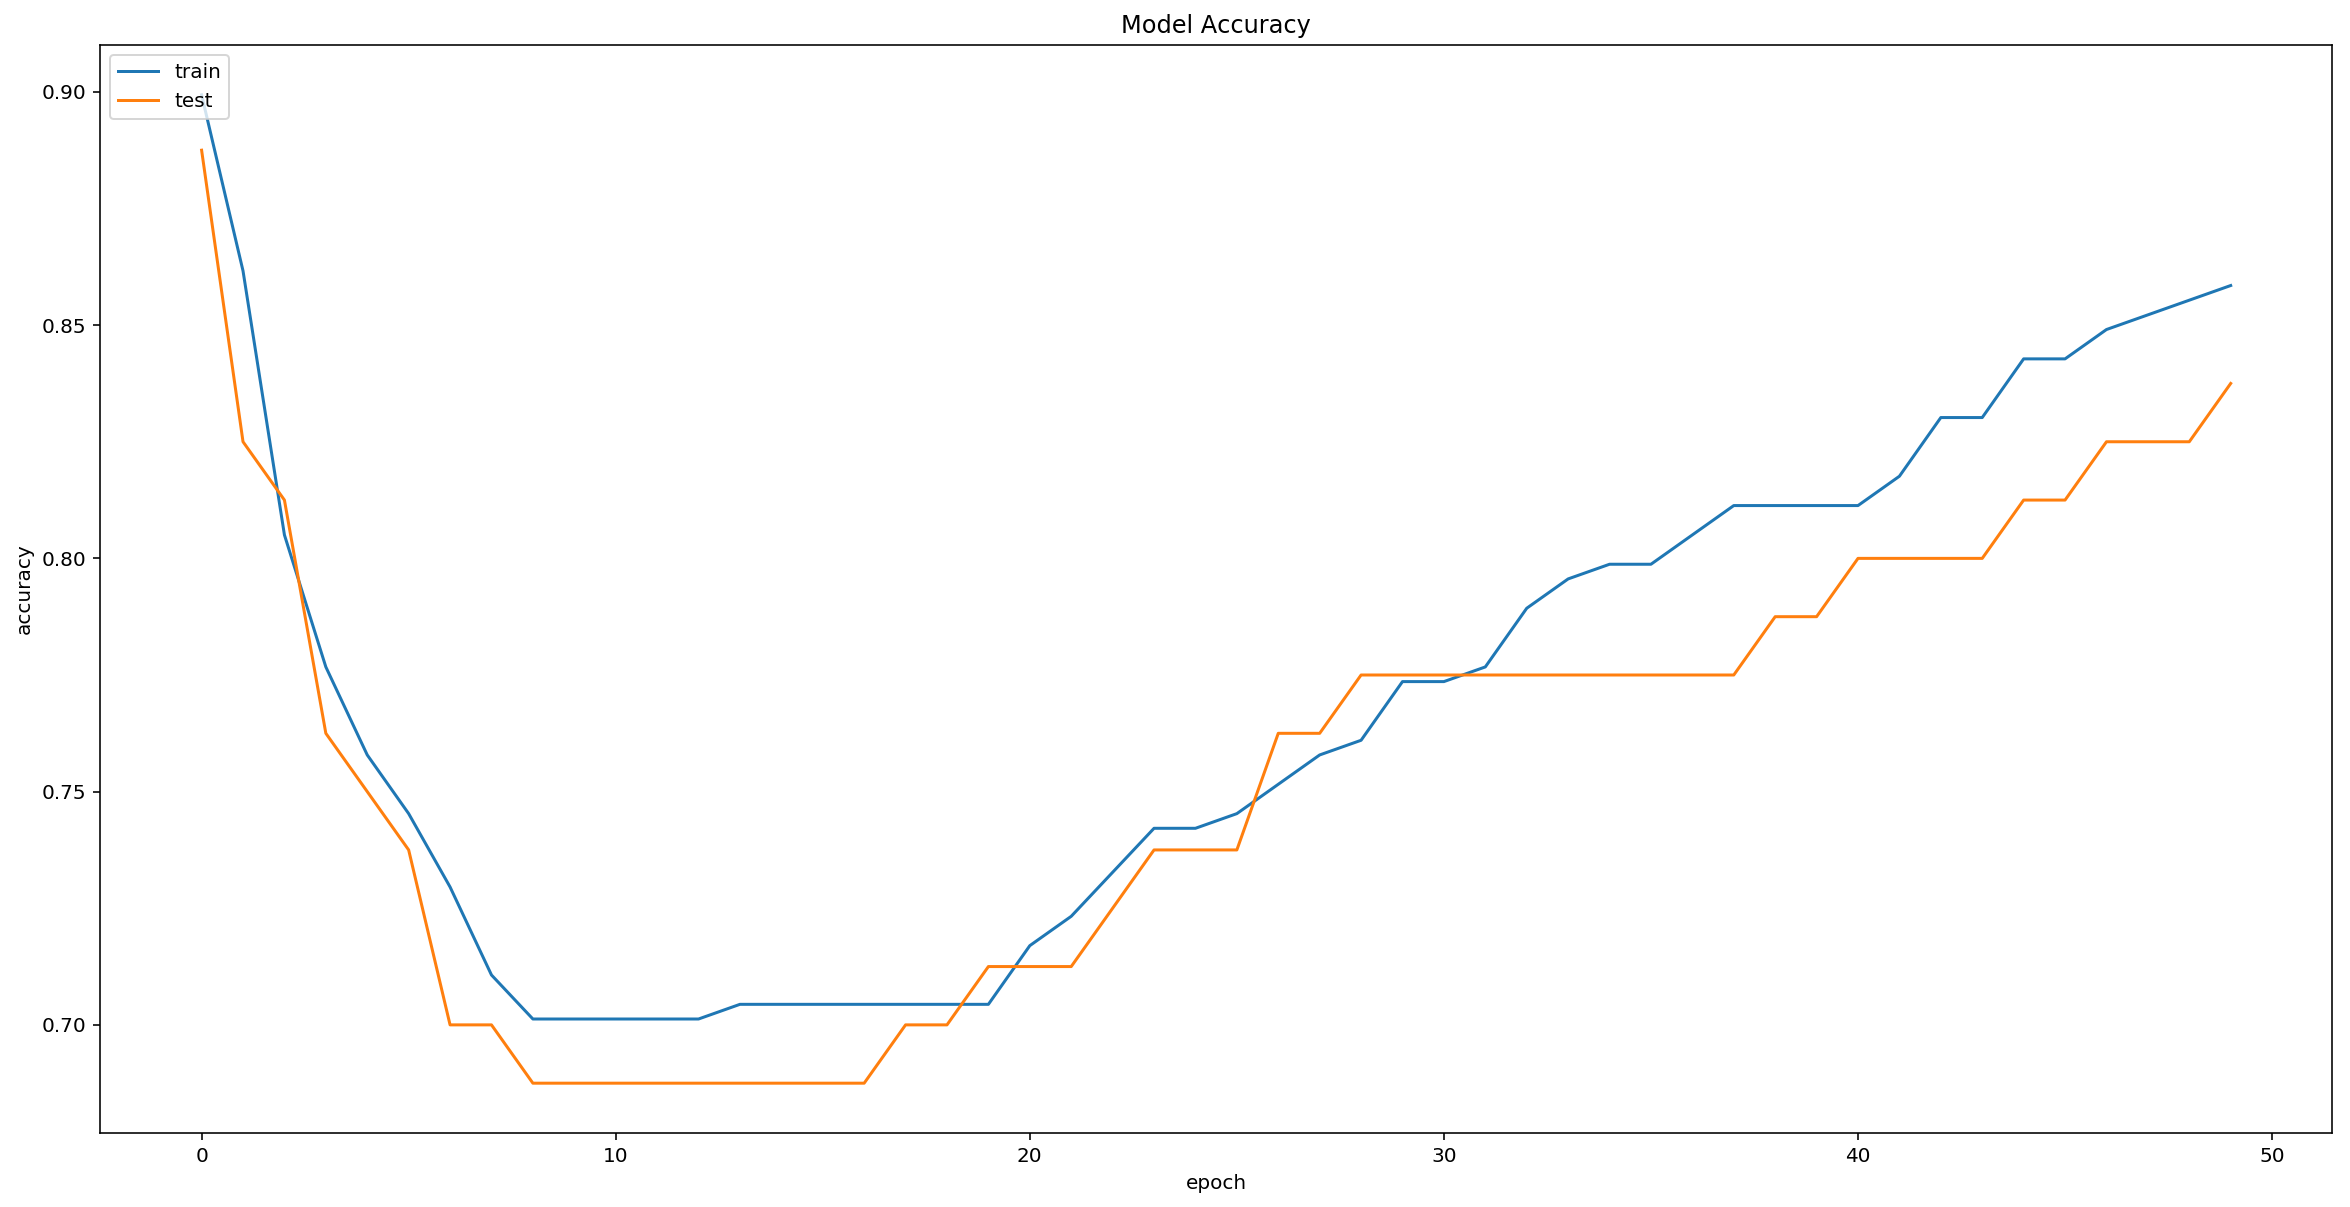

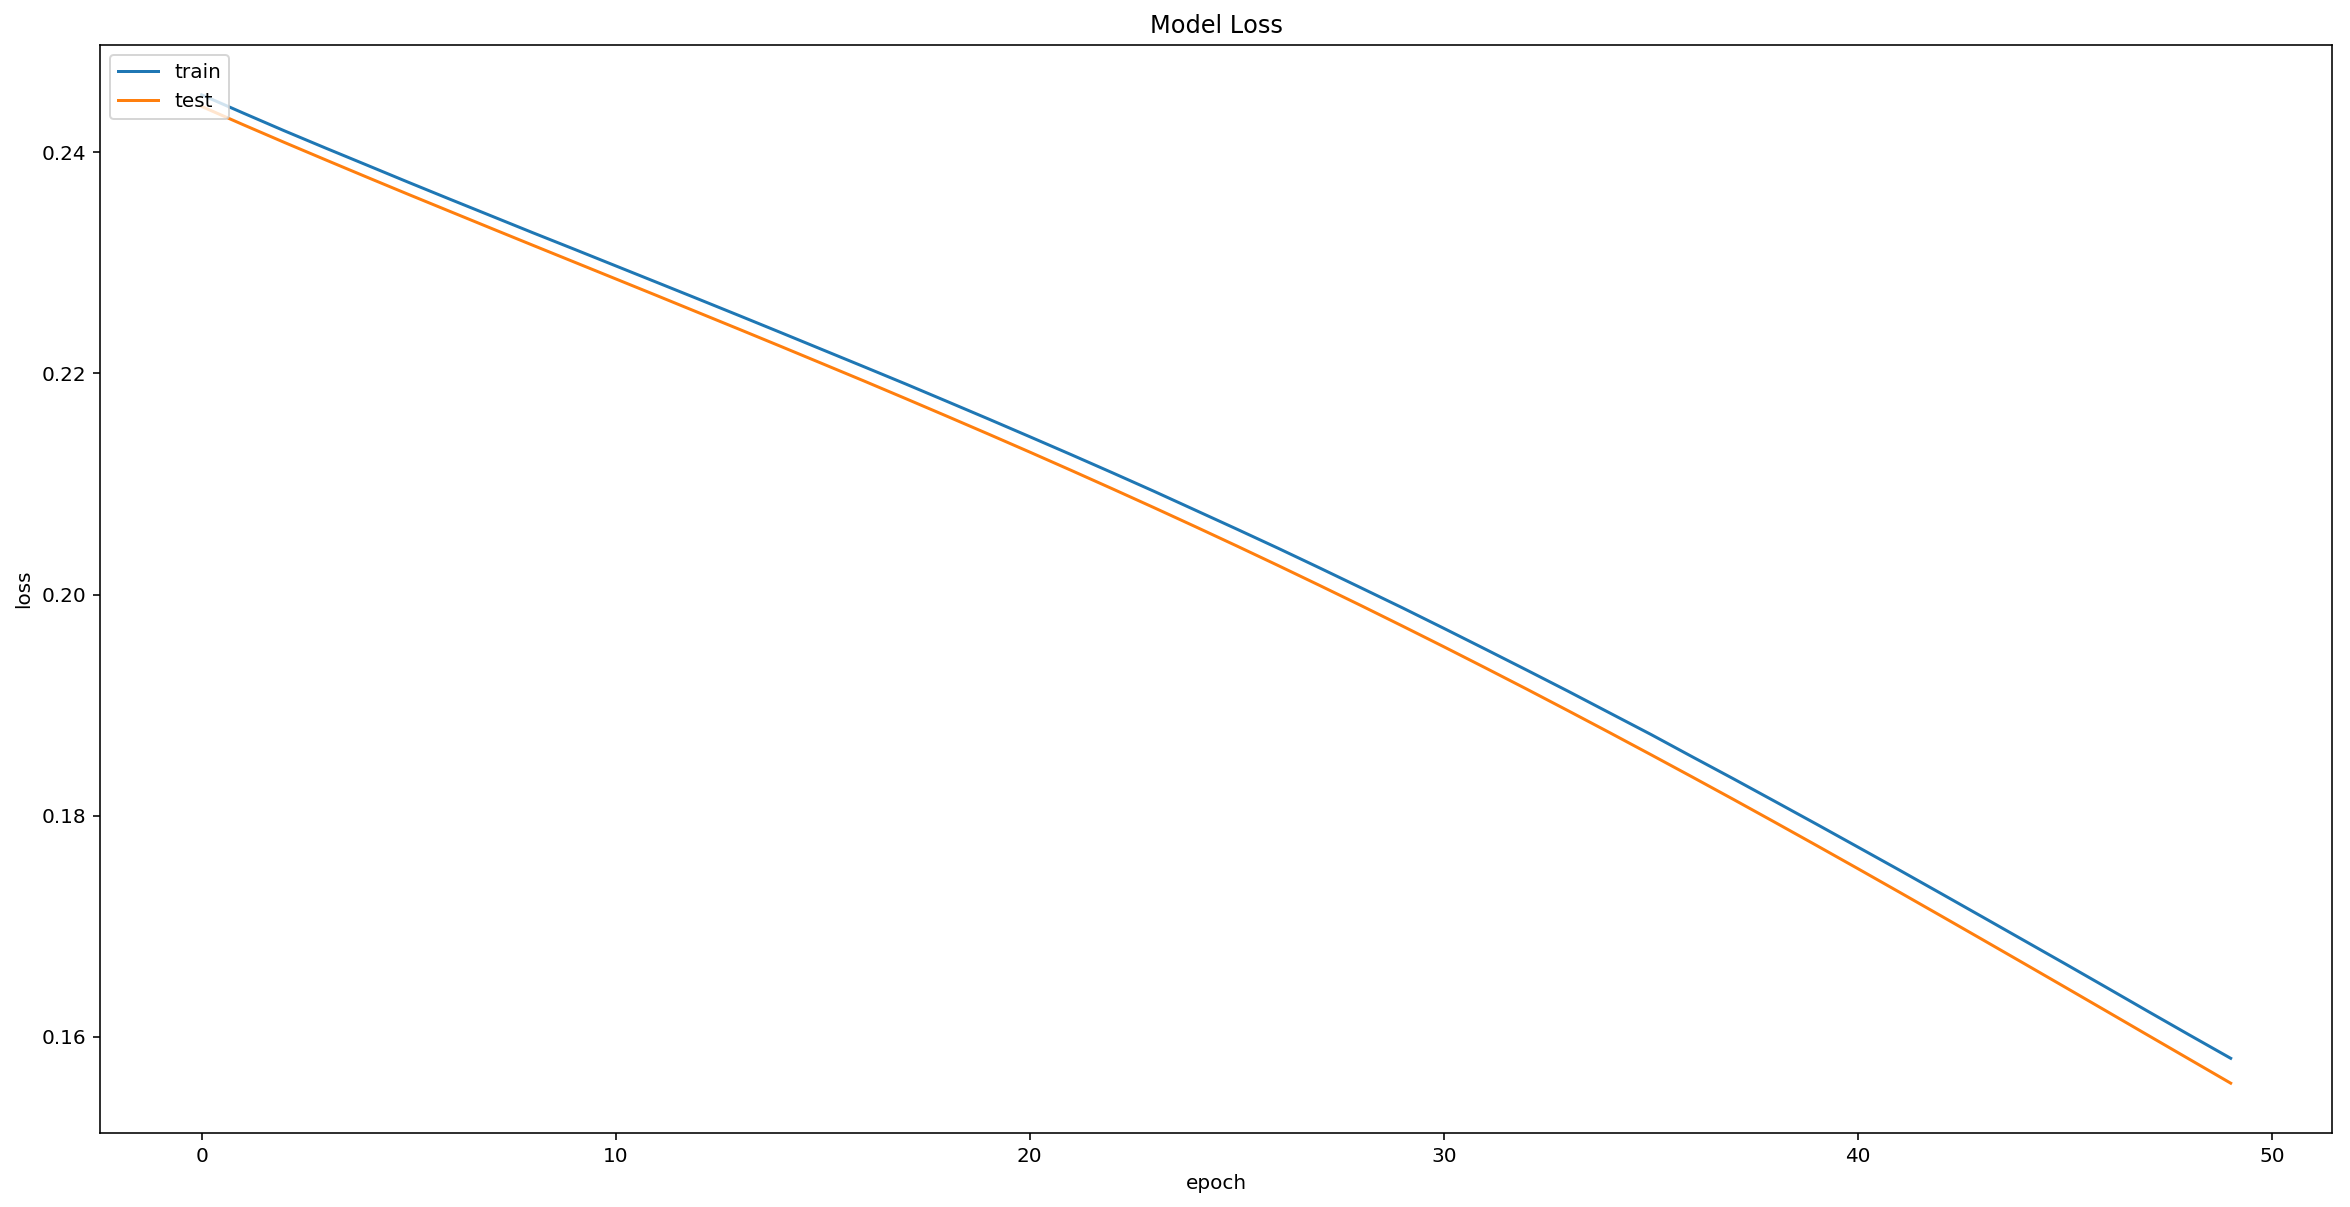

Memory Usage 1.24 MB
Time of Processing 1.50s
Accuracy 91.23%


In [17]:
show_info(model4, X_test_norm, y_test, keras_history4)

In [26]:
# Building the model 5
model5 = Sequential()
model5.add(Dense(128, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='normal'))
model5.add(Dense(64, activation='tanh'))
model5.add(Dense(2, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
model5.compile(loss = 'mean_squared_error', optimizer='sgd', metrics=['accuracy'])
model5.summary()

# Training the model 5
keras_history5 = KerasHistory()
memory_usage = monitor(target=train(model5, X_train_norm, y_train, keras_history5, epochs=1000, batch_size=10))
keras_history5.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 128)               3968      
_________________________________________________________________
dense_26 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 130       
Total params: 12,354
Trainable params: 12,354
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/1000
 - 0s - loss: 0.2421 - acc: 0.7987 - val_loss: 0.2372 - val_acc: 0.9500
Epoch 2/1000
 - 0s - loss: 0.2337 - acc: 0.8868 - val_loss: 0.2290 - val_acc: 0.8750
Epoch 3/1000
 - 0s - loss: 0.2260 - acc: 0.8459 - val_loss: 0.2214 - val_acc: 0.8000
Epoch 4/1000
 - 0s - loss: 0.2188 - acc: 0.8019 - val_loss: 0.2144 - val_acc: 0.7750
Epoch 5/1000
 - 0

Epoch 88/1000
 - 0s - loss: 0.0446 - acc: 0.9528 - val_loss: 0.0392 - val_acc: 0.9500
Epoch 89/1000
 - 0s - loss: 0.0443 - acc: 0.9528 - val_loss: 0.0389 - val_acc: 0.9500
Epoch 90/1000
 - 0s - loss: 0.0440 - acc: 0.9528 - val_loss: 0.0387 - val_acc: 0.9500
Epoch 91/1000
 - 0s - loss: 0.0437 - acc: 0.9528 - val_loss: 0.0384 - val_acc: 0.9500
Epoch 92/1000
 - 0s - loss: 0.0434 - acc: 0.9528 - val_loss: 0.0381 - val_acc: 0.9500
Epoch 93/1000
 - 0s - loss: 0.0431 - acc: 0.9528 - val_loss: 0.0379 - val_acc: 0.9500
Epoch 94/1000
 - 0s - loss: 0.0428 - acc: 0.9528 - val_loss: 0.0376 - val_acc: 0.9500
Epoch 95/1000
 - 0s - loss: 0.0425 - acc: 0.9528 - val_loss: 0.0373 - val_acc: 0.9500
Epoch 96/1000
 - 0s - loss: 0.0423 - acc: 0.9560 - val_loss: 0.0371 - val_acc: 0.9500
Epoch 97/1000
 - 0s - loss: 0.0420 - acc: 0.9560 - val_loss: 0.0369 - val_acc: 0.9500
Epoch 98/1000
 - 0s - loss: 0.0417 - acc: 0.9560 - val_loss: 0.0366 - val_acc: 0.9500
Epoch 99/1000
 - 0s - loss: 0.0415 - acc: 0.9560 - val

Epoch 183/1000
 - 0s - loss: 0.0297 - acc: 0.9748 - val_loss: 0.0251 - val_acc: 0.9750
Epoch 184/1000
 - 0s - loss: 0.0296 - acc: 0.9748 - val_loss: 0.0251 - val_acc: 0.9750
Epoch 185/1000
 - 0s - loss: 0.0295 - acc: 0.9748 - val_loss: 0.0250 - val_acc: 0.9750
Epoch 186/1000
 - 0s - loss: 0.0295 - acc: 0.9748 - val_loss: 0.0249 - val_acc: 0.9875
Epoch 187/1000
 - 0s - loss: 0.0294 - acc: 0.9748 - val_loss: 0.0248 - val_acc: 0.9875
Epoch 188/1000
 - 0s - loss: 0.0293 - acc: 0.9748 - val_loss: 0.0248 - val_acc: 0.9875
Epoch 189/1000
 - 0s - loss: 0.0293 - acc: 0.9748 - val_loss: 0.0247 - val_acc: 0.9875
Epoch 190/1000
 - 0s - loss: 0.0292 - acc: 0.9748 - val_loss: 0.0246 - val_acc: 0.9875
Epoch 191/1000
 - 0s - loss: 0.0291 - acc: 0.9748 - val_loss: 0.0245 - val_acc: 0.9875
Epoch 192/1000
 - 0s - loss: 0.0291 - acc: 0.9748 - val_loss: 0.0245 - val_acc: 0.9875
Epoch 193/1000
 - 0s - loss: 0.0290 - acc: 0.9748 - val_loss: 0.0244 - val_acc: 0.9875
Epoch 194/1000
 - 0s - loss: 0.0289 - acc: 

 - 0s - loss: 0.0251 - acc: 0.9717 - val_loss: 0.0201 - val_acc: 0.9750
Epoch 278/1000
 - 0s - loss: 0.0251 - acc: 0.9717 - val_loss: 0.0201 - val_acc: 0.9750
Epoch 279/1000
 - 0s - loss: 0.0250 - acc: 0.9717 - val_loss: 0.0201 - val_acc: 0.9750
Epoch 280/1000
 - 0s - loss: 0.0250 - acc: 0.9717 - val_loss: 0.0200 - val_acc: 0.9750
Epoch 281/1000
 - 0s - loss: 0.0250 - acc: 0.9717 - val_loss: 0.0200 - val_acc: 0.9750
Epoch 282/1000
 - 0s - loss: 0.0250 - acc: 0.9717 - val_loss: 0.0200 - val_acc: 0.9750
Epoch 283/1000
 - 0s - loss: 0.0249 - acc: 0.9748 - val_loss: 0.0199 - val_acc: 0.9750
Epoch 284/1000
 - 0s - loss: 0.0249 - acc: 0.9717 - val_loss: 0.0199 - val_acc: 0.9750
Epoch 285/1000
 - 0s - loss: 0.0249 - acc: 0.9717 - val_loss: 0.0199 - val_acc: 0.9750
Epoch 286/1000
 - 0s - loss: 0.0248 - acc: 0.9717 - val_loss: 0.0198 - val_acc: 0.9750
Epoch 287/1000
 - 0s - loss: 0.0248 - acc: 0.9717 - val_loss: 0.0198 - val_acc: 0.9750
Epoch 288/1000
 - 0s - loss: 0.0248 - acc: 0.9717 - val_lo

Epoch 372/1000
 - 0s - loss: 0.0229 - acc: 0.9780 - val_loss: 0.0177 - val_acc: 0.9750
Epoch 373/1000
 - 0s - loss: 0.0229 - acc: 0.9780 - val_loss: 0.0177 - val_acc: 0.9750
Epoch 374/1000
 - 0s - loss: 0.0228 - acc: 0.9780 - val_loss: 0.0177 - val_acc: 0.9750
Epoch 375/1000
 - 0s - loss: 0.0228 - acc: 0.9780 - val_loss: 0.0177 - val_acc: 0.9750
Epoch 376/1000
 - 0s - loss: 0.0228 - acc: 0.9780 - val_loss: 0.0176 - val_acc: 0.9750
Epoch 377/1000
 - 0s - loss: 0.0228 - acc: 0.9780 - val_loss: 0.0176 - val_acc: 0.9750
Epoch 378/1000
 - 0s - loss: 0.0228 - acc: 0.9780 - val_loss: 0.0176 - val_acc: 0.9750
Epoch 379/1000
 - 0s - loss: 0.0228 - acc: 0.9780 - val_loss: 0.0176 - val_acc: 0.9750
Epoch 380/1000
 - 0s - loss: 0.0227 - acc: 0.9780 - val_loss: 0.0176 - val_acc: 0.9750
Epoch 381/1000
 - 0s - loss: 0.0227 - acc: 0.9780 - val_loss: 0.0176 - val_acc: 0.9750
Epoch 382/1000
 - 0s - loss: 0.0227 - acc: 0.9780 - val_loss: 0.0175 - val_acc: 0.9750
Epoch 383/1000
 - 0s - loss: 0.0227 - acc: 

 - 0s - loss: 0.0215 - acc: 0.9780 - val_loss: 0.0165 - val_acc: 0.9750
Epoch 467/1000
 - 0s - loss: 0.0215 - acc: 0.9780 - val_loss: 0.0165 - val_acc: 0.9750
Epoch 468/1000
 - 0s - loss: 0.0215 - acc: 0.9780 - val_loss: 0.0164 - val_acc: 0.9750
Epoch 469/1000
 - 0s - loss: 0.0215 - acc: 0.9780 - val_loss: 0.0164 - val_acc: 0.9750
Epoch 470/1000
 - 0s - loss: 0.0215 - acc: 0.9780 - val_loss: 0.0164 - val_acc: 0.9750
Epoch 471/1000
 - 0s - loss: 0.0214 - acc: 0.9780 - val_loss: 0.0164 - val_acc: 0.9750
Epoch 472/1000
 - 0s - loss: 0.0214 - acc: 0.9780 - val_loss: 0.0164 - val_acc: 0.9750
Epoch 473/1000
 - 0s - loss: 0.0215 - acc: 0.9780 - val_loss: 0.0164 - val_acc: 0.9750
Epoch 474/1000
 - 0s - loss: 0.0214 - acc: 0.9780 - val_loss: 0.0164 - val_acc: 0.9750
Epoch 475/1000
 - 0s - loss: 0.0214 - acc: 0.9780 - val_loss: 0.0164 - val_acc: 0.9750
Epoch 476/1000
 - 0s - loss: 0.0214 - acc: 0.9780 - val_loss: 0.0164 - val_acc: 0.9750
Epoch 477/1000
 - 0s - loss: 0.0214 - acc: 0.9780 - val_lo

Epoch 561/1000
 - 0s - loss: 0.0206 - acc: 0.9780 - val_loss: 0.0158 - val_acc: 0.9750
Epoch 562/1000
 - 0s - loss: 0.0205 - acc: 0.9780 - val_loss: 0.0158 - val_acc: 0.9750
Epoch 563/1000
 - 0s - loss: 0.0205 - acc: 0.9780 - val_loss: 0.0158 - val_acc: 0.9750
Epoch 564/1000
 - 0s - loss: 0.0205 - acc: 0.9780 - val_loss: 0.0158 - val_acc: 0.9750
Epoch 565/1000
 - 0s - loss: 0.0205 - acc: 0.9780 - val_loss: 0.0158 - val_acc: 0.9750
Epoch 566/1000
 - 0s - loss: 0.0205 - acc: 0.9780 - val_loss: 0.0158 - val_acc: 0.9750
Epoch 567/1000
 - 0s - loss: 0.0205 - acc: 0.9780 - val_loss: 0.0158 - val_acc: 0.9750
Epoch 568/1000
 - 0s - loss: 0.0205 - acc: 0.9780 - val_loss: 0.0158 - val_acc: 0.9750
Epoch 569/1000
 - 0s - loss: 0.0205 - acc: 0.9780 - val_loss: 0.0158 - val_acc: 0.9750
Epoch 570/1000
 - 0s - loss: 0.0205 - acc: 0.9780 - val_loss: 0.0158 - val_acc: 0.9750
Epoch 571/1000
 - 0s - loss: 0.0204 - acc: 0.9780 - val_loss: 0.0158 - val_acc: 0.9750
Epoch 572/1000
 - 0s - loss: 0.0204 - acc: 

 - 0s - loss: 0.0198 - acc: 0.9811 - val_loss: 0.0155 - val_acc: 0.9875
Epoch 656/1000
 - 0s - loss: 0.0198 - acc: 0.9811 - val_loss: 0.0155 - val_acc: 0.9875
Epoch 657/1000
 - 0s - loss: 0.0198 - acc: 0.9811 - val_loss: 0.0155 - val_acc: 0.9875
Epoch 658/1000
 - 0s - loss: 0.0198 - acc: 0.9811 - val_loss: 0.0155 - val_acc: 0.9875
Epoch 659/1000
 - 0s - loss: 0.0198 - acc: 0.9811 - val_loss: 0.0154 - val_acc: 0.9875
Epoch 660/1000
 - 0s - loss: 0.0198 - acc: 0.9811 - val_loss: 0.0155 - val_acc: 0.9875
Epoch 661/1000
 - 0s - loss: 0.0197 - acc: 0.9811 - val_loss: 0.0154 - val_acc: 0.9875
Epoch 662/1000
 - 0s - loss: 0.0197 - acc: 0.9811 - val_loss: 0.0154 - val_acc: 0.9875
Epoch 663/1000
 - 0s - loss: 0.0197 - acc: 0.9811 - val_loss: 0.0154 - val_acc: 0.9875
Epoch 664/1000
 - 0s - loss: 0.0197 - acc: 0.9811 - val_loss: 0.0155 - val_acc: 0.9875
Epoch 665/1000
 - 0s - loss: 0.0197 - acc: 0.9811 - val_loss: 0.0155 - val_acc: 0.9875
Epoch 666/1000
 - 0s - loss: 0.0197 - acc: 0.9811 - val_lo

Epoch 750/1000
 - 0s - loss: 0.0192 - acc: 0.9811 - val_loss: 0.0153 - val_acc: 0.9875
Epoch 751/1000
 - 0s - loss: 0.0192 - acc: 0.9811 - val_loss: 0.0152 - val_acc: 0.9875
Epoch 752/1000
 - 0s - loss: 0.0192 - acc: 0.9811 - val_loss: 0.0153 - val_acc: 0.9875
Epoch 753/1000
 - 0s - loss: 0.0192 - acc: 0.9811 - val_loss: 0.0153 - val_acc: 0.9875
Epoch 754/1000
 - 0s - loss: 0.0191 - acc: 0.9811 - val_loss: 0.0152 - val_acc: 0.9875
Epoch 755/1000
 - 0s - loss: 0.0191 - acc: 0.9811 - val_loss: 0.0153 - val_acc: 0.9875
Epoch 756/1000
 - 0s - loss: 0.0191 - acc: 0.9811 - val_loss: 0.0153 - val_acc: 0.9875
Epoch 757/1000
 - 0s - loss: 0.0191 - acc: 0.9811 - val_loss: 0.0152 - val_acc: 0.9875
Epoch 758/1000
 - 0s - loss: 0.0191 - acc: 0.9811 - val_loss: 0.0152 - val_acc: 0.9875
Epoch 759/1000
 - 0s - loss: 0.0191 - acc: 0.9811 - val_loss: 0.0152 - val_acc: 0.9875
Epoch 760/1000
 - 0s - loss: 0.0191 - acc: 0.9811 - val_loss: 0.0152 - val_acc: 0.9875
Epoch 761/1000
 - 0s - loss: 0.0191 - acc: 

 - 0s - loss: 0.0187 - acc: 0.9811 - val_loss: 0.0152 - val_acc: 0.9875
Epoch 845/1000
 - 0s - loss: 0.0187 - acc: 0.9811 - val_loss: 0.0152 - val_acc: 0.9875
Epoch 846/1000
 - 0s - loss: 0.0187 - acc: 0.9811 - val_loss: 0.0152 - val_acc: 0.9875
Epoch 847/1000
 - 0s - loss: 0.0187 - acc: 0.9811 - val_loss: 0.0152 - val_acc: 0.9875
Epoch 848/1000
 - 0s - loss: 0.0187 - acc: 0.9811 - val_loss: 0.0152 - val_acc: 0.9875
Epoch 849/1000
 - 0s - loss: 0.0187 - acc: 0.9811 - val_loss: 0.0151 - val_acc: 0.9875
Epoch 850/1000
 - 0s - loss: 0.0186 - acc: 0.9811 - val_loss: 0.0151 - val_acc: 0.9875
Epoch 851/1000
 - 0s - loss: 0.0186 - acc: 0.9811 - val_loss: 0.0151 - val_acc: 0.9875
Epoch 852/1000
 - 0s - loss: 0.0186 - acc: 0.9811 - val_loss: 0.0151 - val_acc: 0.9875
Epoch 853/1000
 - 0s - loss: 0.0186 - acc: 0.9811 - val_loss: 0.0151 - val_acc: 0.9875
Epoch 854/1000
 - 0s - loss: 0.0186 - acc: 0.9811 - val_loss: 0.0152 - val_acc: 0.9875
Epoch 855/1000
 - 0s - loss: 0.0186 - acc: 0.9811 - val_lo

Epoch 939/1000
 - 0s - loss: 0.0182 - acc: 0.9811 - val_loss: 0.0150 - val_acc: 0.9875
Epoch 940/1000
 - 0s - loss: 0.0182 - acc: 0.9811 - val_loss: 0.0150 - val_acc: 0.9875
Epoch 941/1000
 - 0s - loss: 0.0182 - acc: 0.9811 - val_loss: 0.0150 - val_acc: 0.9875
Epoch 942/1000
 - 0s - loss: 0.0182 - acc: 0.9811 - val_loss: 0.0150 - val_acc: 0.9875
Epoch 943/1000
 - 0s - loss: 0.0182 - acc: 0.9811 - val_loss: 0.0150 - val_acc: 0.9875
Epoch 944/1000
 - 0s - loss: 0.0182 - acc: 0.9811 - val_loss: 0.0150 - val_acc: 0.9875
Epoch 945/1000
 - 0s - loss: 0.0182 - acc: 0.9811 - val_loss: 0.0150 - val_acc: 0.9875
Epoch 946/1000
 - 0s - loss: 0.0182 - acc: 0.9811 - val_loss: 0.0150 - val_acc: 0.9875
Epoch 947/1000
 - 0s - loss: 0.0182 - acc: 0.9811 - val_loss: 0.0150 - val_acc: 0.9875
Epoch 948/1000
 - 0s - loss: 0.0182 - acc: 0.9811 - val_loss: 0.0150 - val_acc: 0.9875
Epoch 949/1000
 - 0s - loss: 0.0182 - acc: 0.9811 - val_loss: 0.0150 - val_acc: 0.9875
Epoch 950/1000
 - 0s - loss: 0.0182 - acc: 

## Treinamento 5
Para o treinamento 5 foram utilizados os seguintes hiperparametros:

Épocas = 1000

Batchsize = 10

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 128 e a segunda com 64 e a camada de saída com dois neurônios. Na primeira utilizei a tangente hiperbólica e na segunda a sigmóide como função de ativação.

Nesse ciclo podemos observar os resultados abaixo:

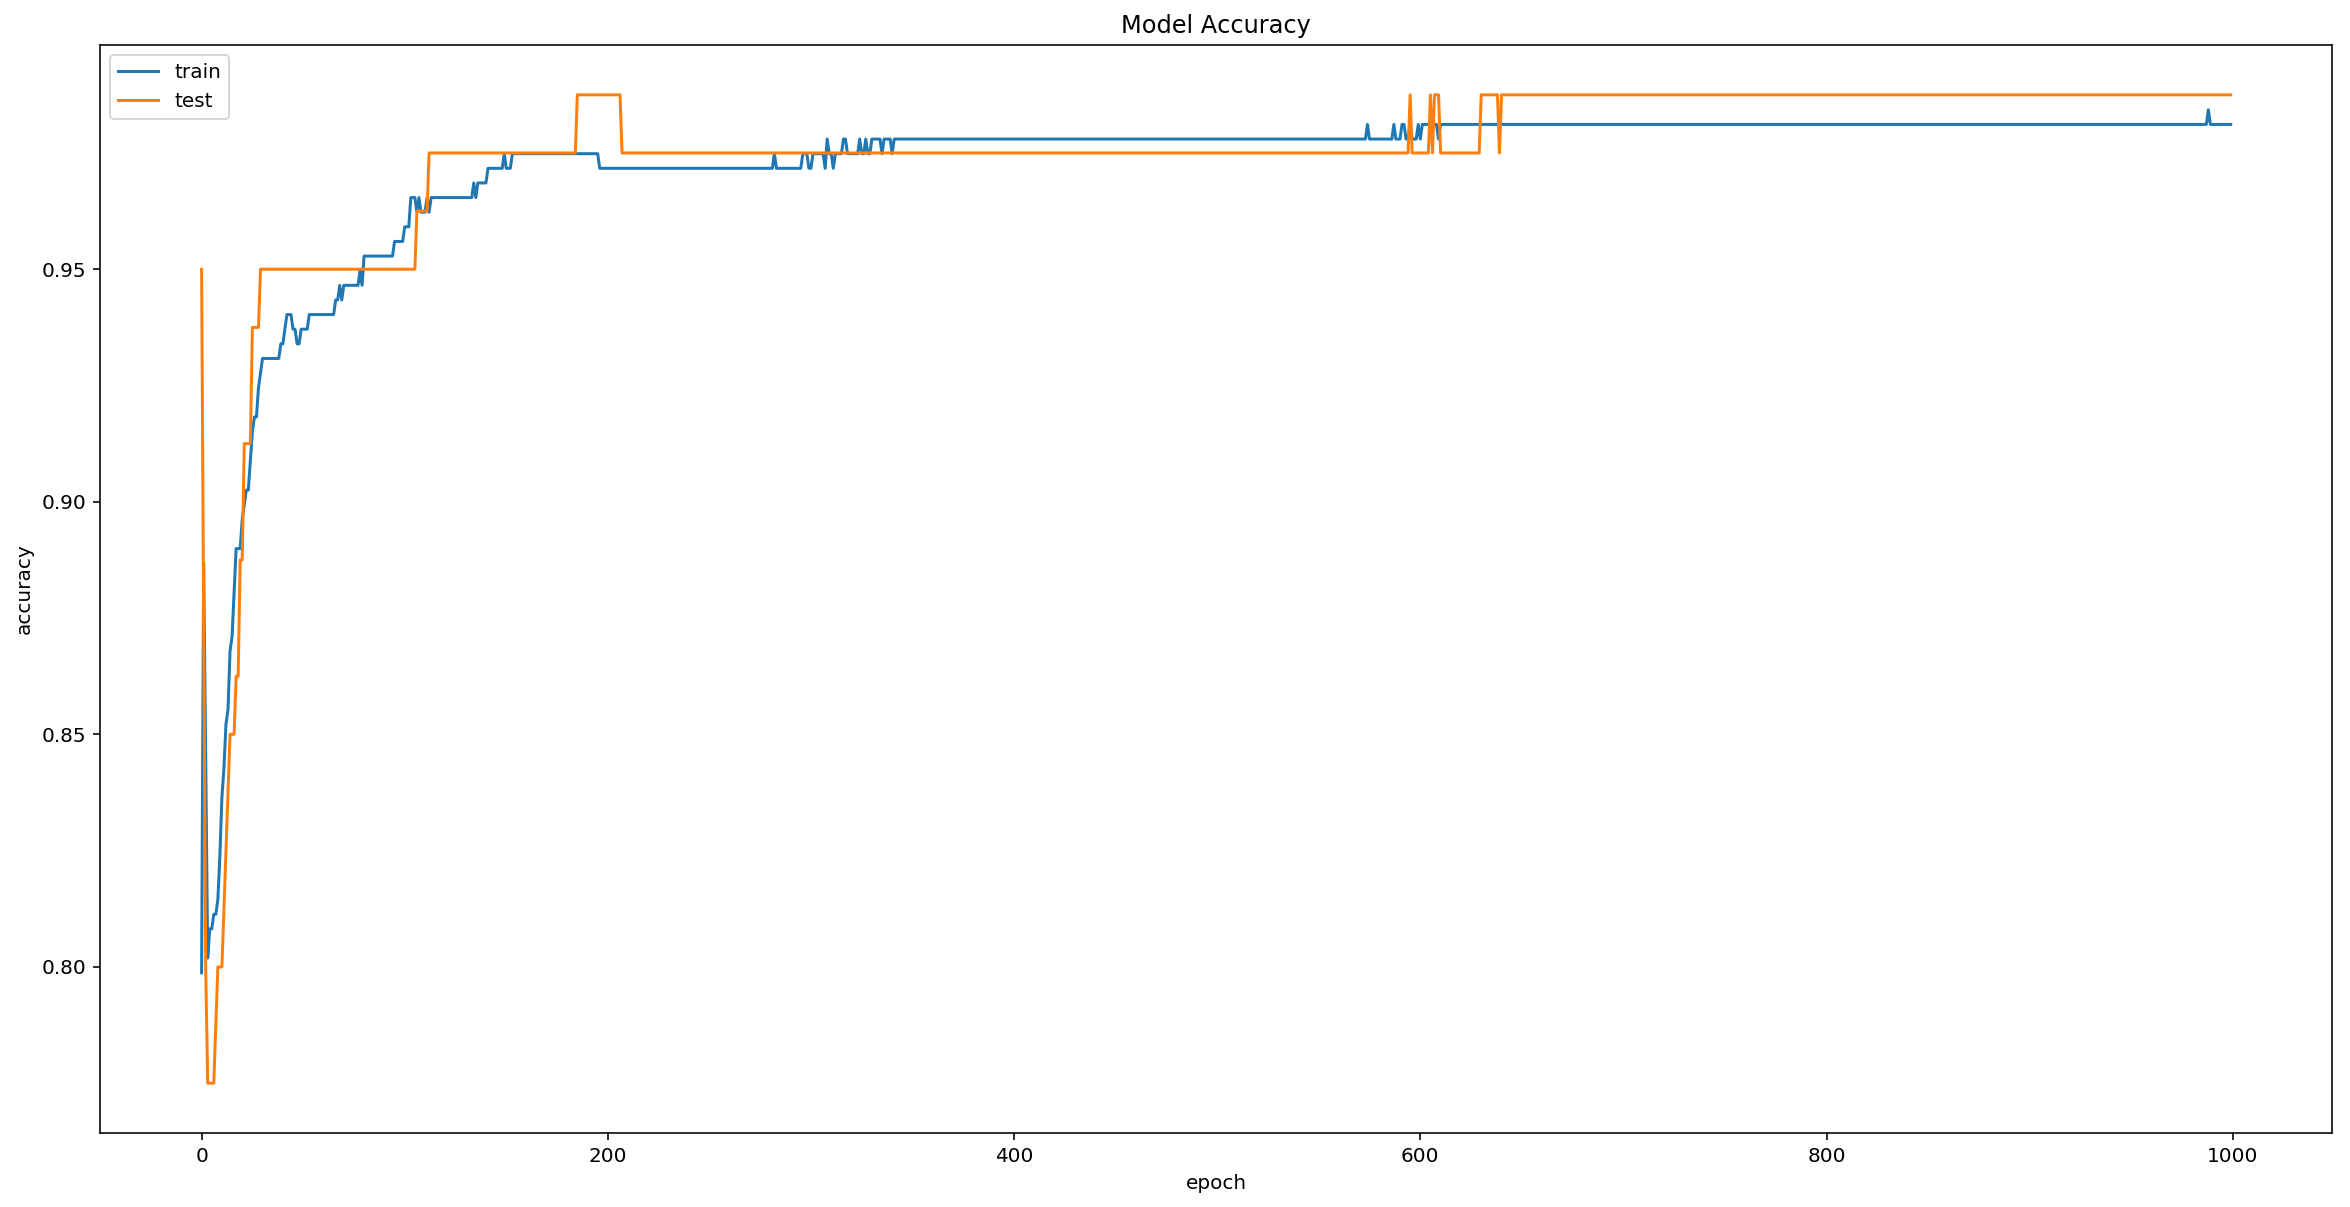

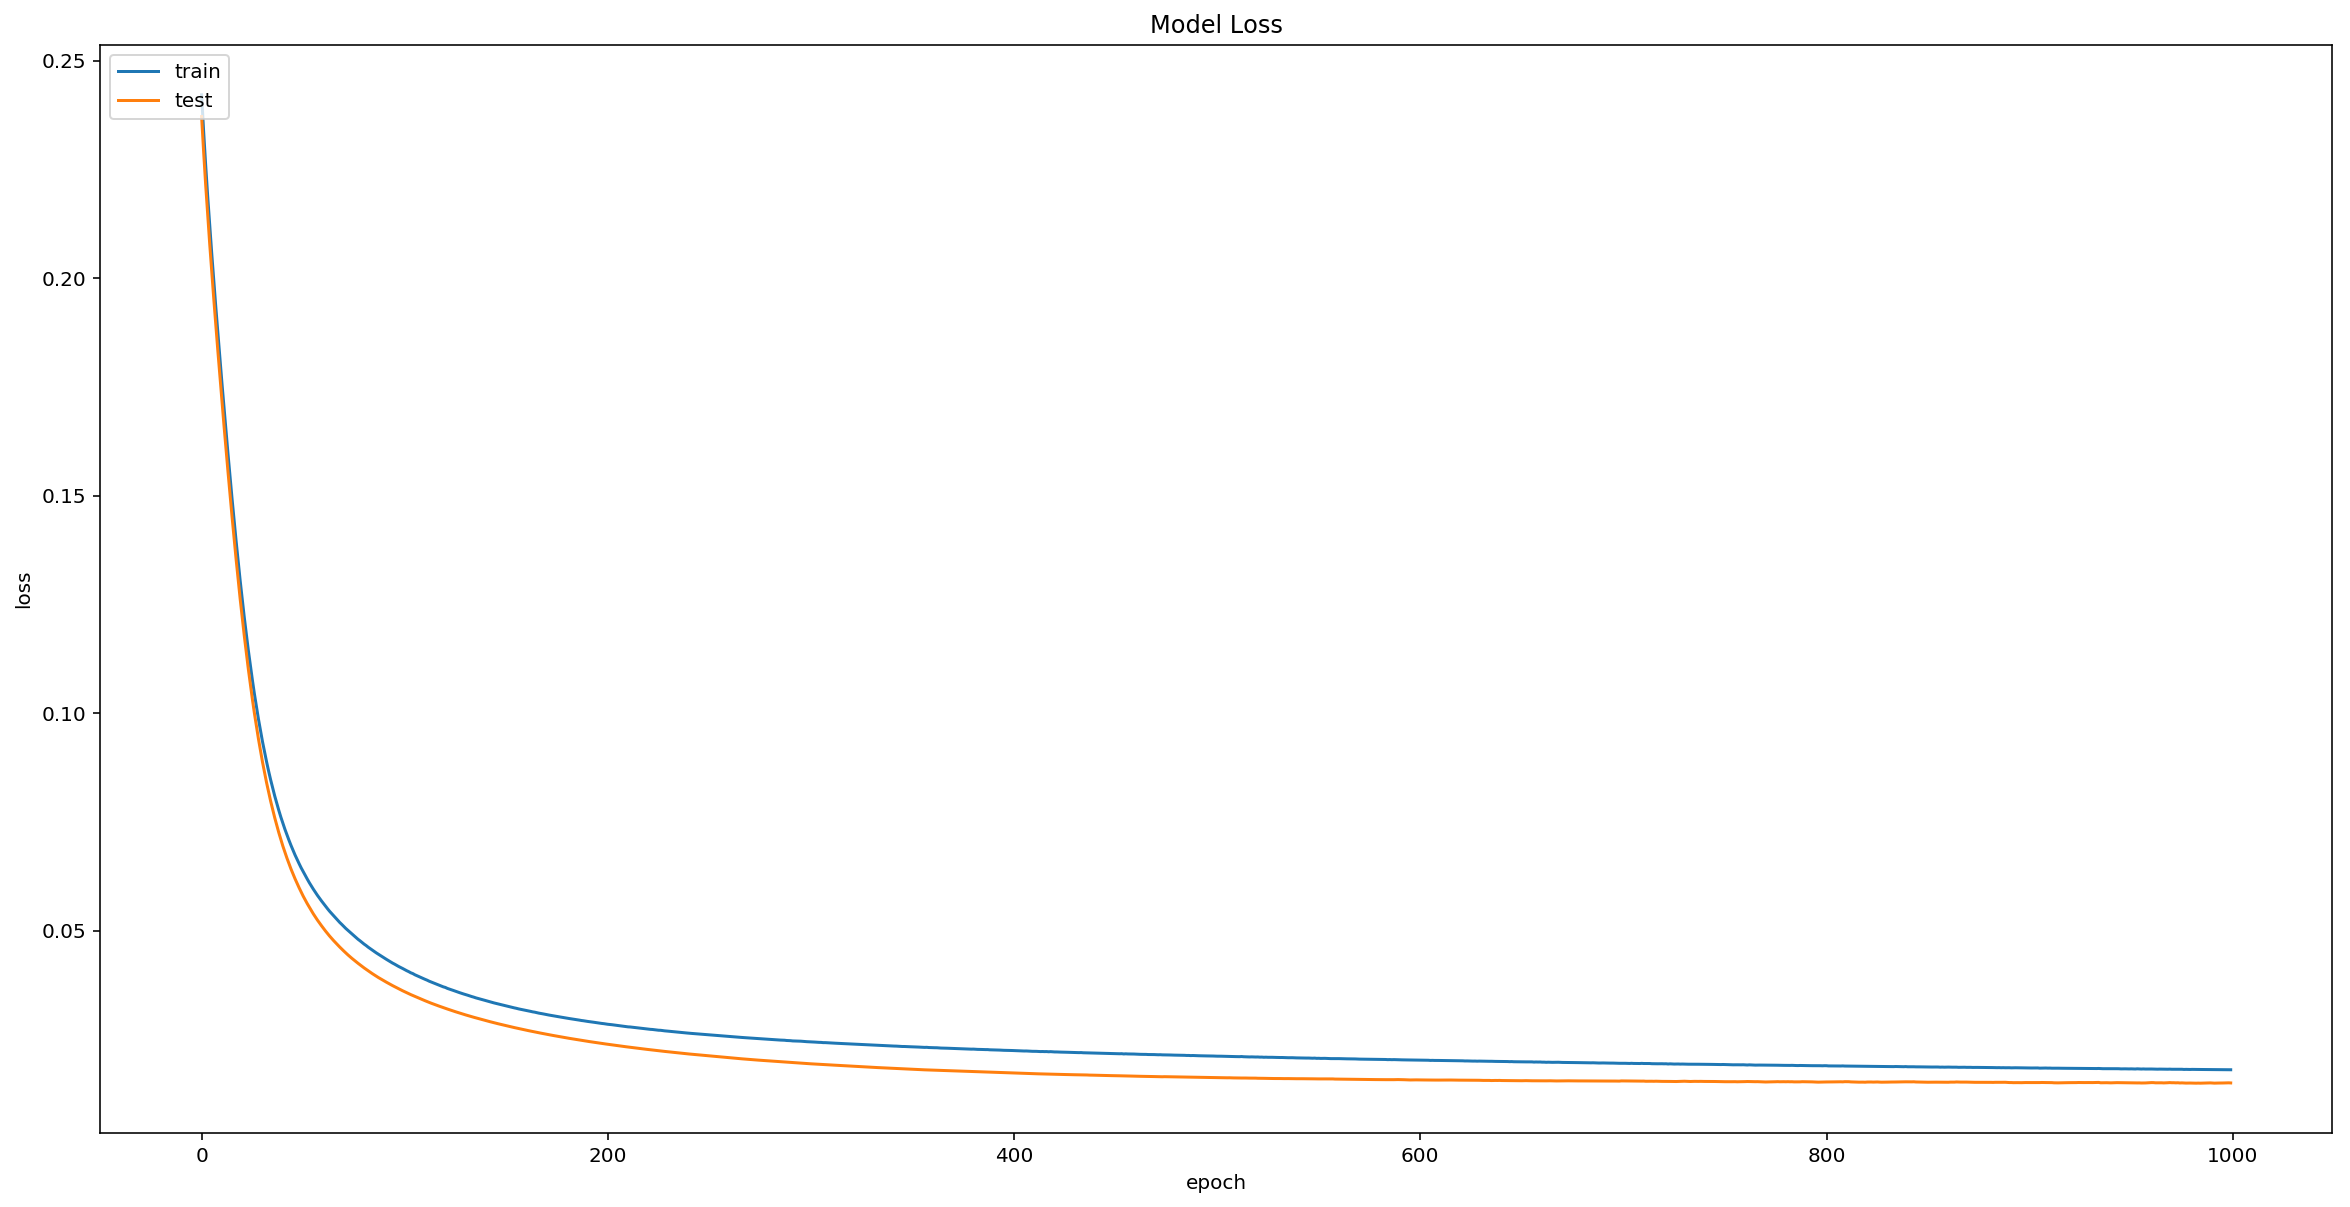

Memory Usage 1.04 MB
Time of Processing 47.33s
Accuracy 97.08%


In [27]:
show_info(model5, X_test_norm, y_test, keras_history5)